In [1]:
# Import necessary libraries used in this notebook
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
from scipy.linalg import svd
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
from tinygp import GaussianProcess, kernels
from jaxtyping import Array, Float
import GPy
jax.config.update("jax_enable_x64", True)
key = jrandom.key(0)
import warnings
from tinygp.kernels import Sum
warnings.filterwarnings("ignore")
import optax
import jax.random as jr
key = jr.key(0)
import torch
import sys
from neuralop.models import FNO
from torch.optim import AdamW
from neuralop.losses.data_losses import LpLoss, H1Loss
from neuralop.utils import count_model_params


# Homework 5

## References

+ Module 4: High-dimensional uncertainty propagation
    - Functional inputs to scientific models
    - Operator learning

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ First Name: Shaunak
+ Last Name: Mukherjee
+ Email: mukher86@purdue.edu
+ Used generative AI to complete this assignment (Yes/No): Yes
+ Which generative AI tool did you use (if applicable)?: ChatGPT

# Problem 1 - Proper Orthogonal Decomposition

Proper orthogonal decomposition (POD) is very closely related to the Karhunen-Loève expansion of a Gaussian random field. 
The main difference is that POD is based on estimating the covariance function from a dataset of realizations of the random field, while the Karhunen-Loève expansion is based on the analytical form of the covariance function of the random field.
In this problem, I will guide you through the steps of deriving POD and highlight the connection to the Karhunen-Loève expansion.

Let $\Omega$ be a subset of $\mathbb{R}^d$ and let $L^2(\Omega)$ be the space of square-integrable functions on $\Omega$.
The inner product in $L^2(\Omega)$ is defined by:

$$
\langle u, v \rangle \equiv u^\dagger v \equiv \int_\Omega u(x) v(x) \, dx.
$$

The dagger notation $\dagger$ makes it easier to write the inner product in a compact form.

Suppose we have a dataset of $N$ functions $\{u_i\}_{i=1}^N \subset L^2(\Omega)$.
These are the realizations of the random field $u(x)$.

Define the empirical mean of any operator or functional $F[u]$ by:

$$
\langle F[u] \rangle = \frac{1}{N} \sum_{i=1}^N F[u_i].
$$

Suppose that we have shifted the functions $\{u_i\}_{i=1}^N$ so that their empirical mean is zero, i.e., $\langle u_i \rangle = 0$ for all $i$.

Define the empirical covariance operator $R: L^2(\Omega) \to L^2(\Omega)$ by:

$$
R\phi = \langle (\phi^\dagger u)u \rangle = \frac{1}{N} \sum_{i=1}^N (\phi^\dagger u_i)u_i.
$$

The POD *modes* are the eigenfunctions of the operator $R$:

$$
R\phi_k = \lambda_k \phi_k.
$$

In this problem, I am asking you to prove some properties of $R$ and the POD modes using just the following properties:

+ The inner produce $u^\dagger v = \langle u, v \rangle$ satisfies the properties of a standard inner product.
+ The empirical mean $\langle F[u] \rangle$ satisfies the basic properties of the expectation value of a random variable.
+ For any *linear* operator $F$, $\langle F[u] \rangle = F[\langle u \rangle]$.

## Part A

Show that the operator $R$ has the kernel representation:

$$
(R\phi)(x) = \int R(x,x') \phi(x') \, dx',
$$

where the kernel $R(x,x')$ is given by:

$$
R(x,x') = \langle u(x) u(x') \rangle.
$$

*Hint: Use the definition of $R$ and the properties of the inner product and the empirical mean.*

Answer:

From the definition of $R$ we have:

$$
R\phi = \langle (\phi^\dagger u) u \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i.
$$

Also,

$$
(\phi^\dagger u_i) = \int \phi(x') u_i(x') \, dx'.
$$

Substituting this into $R\phi$,

$$
(R\phi)(x) = \frac{1}{N} \sum_{i=1}^{N} \left( \int \phi(x') u_i(x') \, dx' \right) u_i(x).
$$

or,

$$
(R\phi)(x) = \int \left( \frac{1}{N} \sum_{i=1}^{N} u_i(x) u_i(x') \right) \phi(x') \, dx'.
$$

Since

$$
R(x, x') = \langle u(x) u(x') \rangle = \frac{1}{N} \sum_{i=1}^{N} u_i(x) u_i(x'),
$$

finally,

$$
(R\phi)(x) = \int R(x, x') \phi(x') \, dx'.
$$

$QED$


## Part B

Show that the operator $R$ is linear, i.e.,

$$
R(\alpha \phi + \beta \psi) = \alpha R\phi + \beta R\psi.
$$

Answer:

We start with the definition again,
$$
R\phi = \langle (\phi^\dagger u) u \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i.
$$

Applying to $\alpha \phi + \beta \psi$:

$$
R(\alpha \phi + \beta \psi) = \left\langle \left( (\alpha \phi + \beta \psi)^\dagger u \right) u \right\rangle
$$

Using the linearity of the inner product,

$$
(\alpha \phi + \beta \psi)^\dagger u = \alpha (\phi^\dagger u) + \beta (\psi^\dagger u)
$$

Thus, we obtain:

$$
R(\alpha \phi + \beta \psi) = \left\langle (\alpha (\phi^\dagger u) + \beta (\psi^\dagger u)) u \right\rangle
$$


Since the empirical mean satisfies the linearity property as provided in the problem,

$$
\langle F[u] + G[u] \rangle = \langle F[u] \rangle + \langle G[u] \rangle
$$

we get, 
$$
R(\alpha \phi + \beta \psi) = \alpha \langle (\phi^\dagger u) u \rangle + \beta \langle (\psi^\dagger u) u \rangle
$$

Recognizing the definitions of $R\phi$ and $R\psi$:

$$
R(\alpha \phi + \beta \psi) = \alpha R\phi + \beta R\psi.
$$

$QED$

## Part C

Show that the operator $R$ is bounded, in the sense that

$$
\| R\phi \| \leq C \| \phi \|
$$

for some constant $C$ that does not depend on $\phi$.

*Hint: Use the triangle inequality for norms and the Cauchy-Schwarz inequality.*

Answer:


By definition, the operator $R$:

$$
R\phi = \langle (\phi^\dagger u) u \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i
$$

Taking the $L^2$ norm on both sides,

$$
\| R\phi \| = \left\| \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i \right\|.
$$

Using the triangle inequality,

$$
\| R\phi \| \leq \frac{1}{N} \sum_{i=1}^{N} | \phi^\dagger u_i | \| u_i \|
$$

We apply the Cauchy-Schwarz inequality:

$$
| \phi^\dagger u_i | = | \langle \phi, u_i \rangle | \leq \| \phi \| \| u_i \|
$$

Substituting we get,

$$
\| R\phi \| \leq \frac{1}{N} \sum_{i=1}^{N} \| \phi \| \| u_i \|^2.
$$

Rearranging,

$$
\| R\phi \| \leq \| \phi \| \cdot \frac{1}{N} \sum_{i=1}^{N} \| u_i \|^2
$$

Let constant C:

$$
C = \frac{1}{N} \sum_{i=1}^{N} \| u_i \|^2.
$$

Since $C$ depends only on $\{u_i\}$ and not on $\phi$, Ttis shows that the operator R is bounded.


$$
\| R\phi \| \leq C \| \phi \|.
$$

$QED$

## Part D

Show that $R$ is continuous.

*Hint: It sufficies to show that if $\|\phi_n - \phi\| \to 0$, then $\|R\phi_n - R\phi\|\to 0$. Use the fact that $R$ is bounded.*

Answer:

Since \( R \) is linear,

$$
R\phi_n - R\phi = R(\phi_n - \phi).
$$

Taking the norm on both sides,

$$
\| R\phi_n - R\phi \| = \| R(\phi_n - \phi) \|.
$$

Since R is bounded, there exists a constant \( C > 0 \)

$$
\| R\phi \| \leq C \| \phi \|, \quad \forall \phi \in L^2(\Omega)
$$

so,

$$
\| R(\phi_n - \phi) \| \leq C \| \phi_n - \phi \|
$$

Since $\phi_n \to \phi$ in $L^2(\Omega)$, we have:

$$
\| \phi_n - \phi \| \to 0 \quad \text{as } n \to \infty.
$$



$$
\| R\phi_n - R\phi \| \leq C \| \phi_n - \phi \| \to 0.
$$

Thus,

$$
\| R\phi_n - R\phi \| \to 0 \quad \text{as } n \to \infty.
$$

$QED$

## Part E

The adjoint of an operator $A$ is the operator $A^\dagger$ such that

$$
\langle A\phi, \psi \rangle = \langle \phi, A^\dagger \psi \rangle.
$$

It is easier to understand the adjoint using the dagger notation:

$$
(A\phi)^\dagger \psi = \phi^\dagger (A^\dagger \psi).
$$

That is, you can think of the adjoint as the transpose of a real matrix (or the conjugate transpose of a complex matrix).
Show that $R$ is self-adjoint when $R^\dagger = R$, i.e.,

$$
\langle R\phi, \psi \rangle = \langle \phi, R\psi \rangle,
$$

or equivalently in terms of the dagger notation:

$$
(R\phi)^\dagger \psi = \phi^\dagger (R\psi) = \phi^\dagger R\psi.
$$

So, you can think of the self-adjoint property as the analog of a real matrix being symmetric or a complex matrix being Hermitian.

*Hint: Just start with the left hand side, use the definition of $R$, the properties of the inner product and the empirical mean, and the fact that the inner product is a scalar.*

Answer:

We have R:

$$
R\phi = \langle (\phi^\dagger u) u \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i
$$

Taking the inner product with $\psi$

$$
\langle R\phi, \psi \rangle = \left\langle \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i, \psi \right\rangle
$$

or,

$$
\langle R\phi, \psi \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) \langle u_i, \psi \rangle
$$

or,

$$
\langle R\phi, \psi \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) (u_i^\dagger \psi)
$$

inner product is commutative for scalars,

$$
(\phi^\dagger u_i)(u_i^\dagger \psi) = (\psi^\dagger u_i)(u_i^\dagger \phi).
$$

Thus:

$$
\langle R\phi, \psi \rangle = \frac{1}{N} \sum_{i=1}^{N} (\psi^\dagger u_i) (u_i^\dagger \phi)
$$

Rewriting the sum,

$$
\langle R\phi, \psi \rangle = \left\langle \frac{1}{N} \sum_{i=1}^{N} (\psi^\dagger u_i) u_i, \phi \right\rangle.
$$

Using the definition of $R$ again,

$$
R\psi = \frac{1}{N} \sum_{i=1}^{N} (\psi^\dagger u_i) u_i.
$$

Thus,

$$
\langle R\phi, \psi \rangle = \langle \phi, R\psi \rangle.
$$

Since $\langle R\phi, \psi \rangle = \langle \phi, R\psi \rangle$ for all $\phi, \psi \in L^2(\Omega)$, we conclude that $R$ is self-adjoint, i.e.,

$$R^\dagger = R$$

$QED$

## Part F

Show that $R$ is positive semi-definite, i.e.,

$$
\langle R\phi, \phi \rangle \geq 0,
$$

or equivalently in terms of the dagger notation:

$$
\phi^\dagger R\phi \geq 0.
$$

Answer:

The inner product,

$$
\langle R\phi, \phi \rangle = \left\langle \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) u_i, \phi \right\rangle
$$

Using the linearity of the inner product,

$$
\langle R\phi, \phi \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) \langle u_i, \phi \rangle
$$

Since $\phi^\dagger u_i$ is a scalar,

$$
\langle R\phi, \phi \rangle = \frac{1}{N} \sum_{i=1}^{N} (\phi^\dagger u_i) (\phi^\dagger u_i).
$$

Each term in the sum $|\phi^\dagger u_i|^2$ >0, Therefore,

$$
\langle R\phi, \phi \rangle = \frac{1}{N} \sum_{i=1}^{N} |\phi^\dagger u_i|^2 \geq 0.
$$

Thus, \( R \) is positive semi-definite.

$QED$


## Part G

$R$ is also [compact](https://en.wikipedia.org/wiki/Compact_operator), but it is harder to show this property.
In any case, because $R$ is linear, bounded, self-adjoint, compact, and positive semi-definite, it has a complete set of orthonormal eigenfunctions $\{\phi_k\}_{k=1}^\infty$ and corresponding non-negative eigenvalues $\{\lambda_k\}_{k=1}^\infty$.

Show that we can represent $R$ using the spectral decomposition:

$$
R = \sum_{k=1}^\infty \lambda_k \phi_k \phi_k^\dagger.
$$

You can think of $\phi_k \phi_k^\dagger$ as the analog of a rank-one matrix.
It is defined in terms of its application to a function $\psi$ as:

$$
(\phi_k \phi_k^\dagger \psi)(x) = \phi_k(x) (\phi_k^\dagger\psi),
$$

since $\phi_k^\dagger\psi$ is a scalar.

*Hint: Take an arbitrary function $\psi$ and expand it in the basis of eigenfunctions $\{\phi_k\}_{k=1}^\infty$. Then show that applying $R$ to it gives the same result as applying the right-hand-side of the above expression.*

Answer:

$R$ is compact, self-adjoint, positive semi-definite operator with eigenfunctions $\{\phi_k\}_{k=1}^\infty$ and eigenvalues $\{\lambda_k\}_{k=1}^\infty$ as provided earlier.

$$
R = \sum_{k=1}^\infty \lambda_k \phi_k \phi_k^\dagger,
$$

where $\phi_k \phi_k^\dagger$ is a rank-one matrix. When applying this operator to function $\psi$,

$$
(\phi_k \phi_k^\dagger \psi)(x) = \phi_k(x) (\phi_k^\dagger \psi),
$$

Expanding any function $\psi \in L^2(\Omega)$ in terms of the eigenfunctions $\{\phi_k\}_{k=1}^\infty$, 

$$
\psi = \sum_{k=1}^\infty \langle \phi_k, \psi \rangle \phi_k.
$$

When applying $R$ to $\psi$,

$$
R\psi = \sum_{k=1}^\infty \langle \phi_k, \psi \rangle R\phi_k = \sum_{k=1}^\infty \langle \phi_k, \psi \rangle \lambda_k \phi_k.
$$

Hence we get spectral decomposition of $R$, showing that:

$$
R = \sum_{k=1}^\infty \lambda_k \phi_k \phi_k^\dagger.
$$

$QED$


## Part H

Show that the spectral decomposition of the kernel $R(x,x')$ is:

$$
R(x,x') = \sum_{k=1}^\infty \lambda_k \phi_k(x) \phi_k(x').
$$

Answer:

Earlier we have,

$$
R(x, x') = \langle u(x) u(x') \rangle,
$$

$\langle u(x) u(x') \rangle$ represents the covariance function. 

Since $R$ is a compact, self-adjoint, positive semi-definite,
$$
R = \sum_{k=1}^\infty \lambda_k \phi_k \phi_k^\dagger.
$$

Here, $\lambda_k > 0$, and $\phi_k$ are the eigenfunctions of $R$.


Now, we represent the kernel $R(x, x')$ in terms of its eigenfunctions and eigenvalues

$$
R\psi = \sum_{k=1}^\infty \lambda_k \langle \phi_k, \psi \rangle \phi_k.
$$

Applying the operator $R$ to $\psi(x)$,

$$
(R\psi)(x) = \sum_{k=1}^\infty \lambda_k \langle \phi_k, \psi \rangle \phi_k(x)
$$

Now, we compute the inner product $\langle R\phi, \psi \rangle$

$$
\langle R\phi, \psi \rangle = \int_\Omega R(x, x') \phi(x') \psi(x') \, dx' \, dx.
$$


Using the spectral decomposition of $R$, 

$$
R(x, x') = \sum_{k=1}^\infty \lambda_k \phi_k(x) \phi_k(x').
$$

So, $R(x, x')$ can be expressed as the sum of the eigenfunctions $\phi_k(x)$ and the corresponding eigenvalues $\lambda_k$.



The spectral decomposition of the kernel $R(x, x')$ is:

$$
R(x,x') = \sum_{k=1}^\infty \lambda_k \phi_k(x) \phi_k(x').
$$

$QED$

## Part I

Okay, I hope you have identified the connection between the POD modes and the Karhunen-Loève expansion of a Gaussian random field.
This is is:

+ In POD, we use look at the eigenfunctions of the empirical covariance operator $R$, or equivalently the eigenfunctions of the kernel $R(x,x')$. We can estimate the eigenfunctions and eigenvalues of $R$ from a dataset of realizations of the random field.
+ In the Karhunen-Loève expansion, we use the eigenfunctions of the covariance function $k(x,x')$ of the random field. Someone gives us the analytical form of $k(x,x')$ and we can compute the eigenfunctions and eigenvalues of $k(x,x')$ analytically, e.g., using the Nyström method.

Now we are in a position to explain why we call the sum of the eigenvalues of $R$ (or equivalently the sum of the eigenvalues of $k(x,x')$) the *energy* of the random field.
Where is this coming from?

Suppose $u$ is one component of the velocity field of a fluid flow of constant density $\rho$.
The kinetic energy stored in this component of the fluid velocity is:

$$
K[u] = \frac{1}{2}\rho \int_\Omega u(x)^2 \, dx = \frac{1}{2}\|u\|^2.
$$

Show that the empirical mean of the kinetic energy is:

$$
\bar{K} = \langle K[u] \rangle = \frac{1}{2}\rho \sum_{i=1}^\infty \lambda_i.
$$

Answer:

The kinetic energy of a velocity component \( u(x) \) in a fluid of constant density $ \rho $

$$
K[u] = \frac{1}{2} \rho \int_{\Omega} u(x)^2 \, dx.
$$

Taking the empirical mean over realizations of the random field \( u(x) \),

$$
\bar{K} = \left\langle \frac{1}{2} \rho \int_{\Omega} u(x)^2 \, dx \right\rangle.
$$

Using the linearity of expectation

$$
\bar{K} = \frac{1}{2} \rho \int_{\Omega} \langle u(x)^2 \rangle \, dx.
$$

now,

$$
u(x) = \sum_{i=1}^{\infty} a_i \phi_i(x),
$$

where $\ a_i $ random coefficients with zero mean and variance $ \lambda_i $, i.e.,

$$
\langle a_i a_j \rangle = \lambda_i \delta_{ij}.
$$

or,

$$
u(x)^2 = \sum_{i=1}^{\infty} \sum_{j=1}^{\infty} a_i a_j \phi_i(x) \phi_j(x).
$$

or,

$$
\langle u(x)^2 \rangle = \sum_{i=1}^{\infty} \lambda_i \phi_i(x)^2.
$$

Substituting this into the integral for \( \bar{K} \):

$$
\bar{K} = \frac{1}{2} \rho \int_{\Omega} \sum_{i=1}^{\infty} \lambda_i \phi_i(x)^2 \, dx.
$$

Using the orthonormality of \( \phi_i(x) \):

$$
\int_{\Omega} \phi_i(x)^2 \, dx = 1.
$$

Thus, the integral,

$$
\bar{K} = \frac{1}{2} \rho \sum_{i=1}^{\infty} \lambda_i.
$$

We have shown that the empirical mean of the kinetic energy satisfies:

$$
\bar{K} = \frac{1}{2} \rho \sum_{i=1}^{\infty} \lambda_i.
$$

Hence $QED$

## Problem 2 - POD of fluid flow

Let's give POD, aka empirical Karhunen-Loève expansion, a try!

In this problem, we will apply POD on fluid flow.
We will use the 2D Navier-Stokes solution data set from Wang & Perdikaris (https://arxiv.org/abs/2203.07404).
The data contain the magnitude of a 2D fluid flow velocity field at different times.
You can see a video of it here:

<video width=" " height=" " 
       src="https://user-images.githubusercontent.com/3844367/152894393-6fbc5e1e-f2b0-419e-aa74-3ecb17d0e23e.mp4" 
       controls>
</video>

You can download the data using the following command:

In [2]:
!curl -O https://raw.githubusercontent.com/PredictiveIntelligenceLab/CausalPINNs/main/data/NS.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.6M  100 12.6M    0     0  11.0M      0  0:00:01  0:00:01 --:--:-- 11.0M


You can load the data like this:

In [3]:
import numpy as np

data = np.load('NS.npy', allow_pickle=True)

In [4]:
if isinstance(data.item(), dict):
    print("Keys:", data.item().keys())

Keys: dict_keys(['sol', 'u0', 'v0', 'w0', 'x', 'y', 't', 'viscosity'])


And you should work with the velocity magnitude:

In [5]:
vel_mag = data.item()['sol']
vel_mag.shape

(200, 128, 128)

You will also need the times at which the data were collected:

In [6]:
times = data.item()['t']
times.max()

1.99

And the spatial grid:

In [7]:
x = data.item()['x']
y = data.item()['y']
X1, X2 = np.meshgrid(x, y)

## Part A - Singular value decomposition

Arrange all your data in a big matrix $\mathbf{X}$ such that each row is a snapshot of the velocity field.
That is, each row should be a flattened version of the velocity magnitude at a given time.
Then, compute the economy version of the singular value decomposition (SVD) of $\mathbf{X}$:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T.
$$

*Hint: Use the function `scipy.linalg.svd`.*

Answer:

Velocity reshaped (200, 16384)
Shape of U: (200, 200)
Shape of s: (200,)
Shape of Vt: (200, 16384)


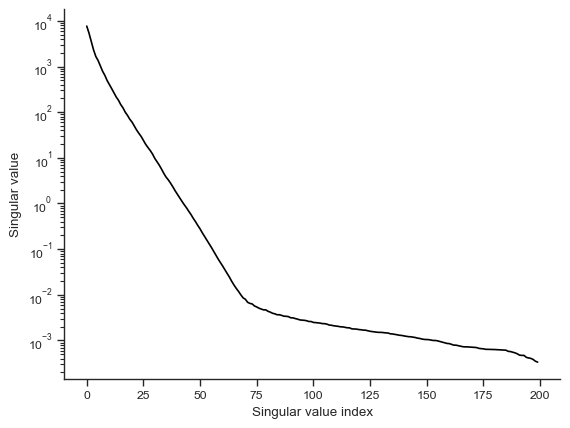

In [8]:
# Your code here (https://predictivesciencelab.github.io/advanced-scientific-machine-learning/reduced_order_modeling/01_svd.html)

# Reshape velocity field i.e. each row is a flattened snapshot
X = vel_mag.reshape(vel_mag.shape[0], -1)
print(f"Velocity reshaped {X.shape}") 

# Compute the economy SVD
U, s, VT = svd(X, full_matrices=False)

# Print shapes 
print("Shape of U:", U.shape) 
print("Shape of s:", s.shape) 
print("Shape of Vt:", VT.shape) 

# Plot the singular values

fig, ax = plt.subplots()
ax.plot(s, color='black')
ax.set(yscale='log', xlabel="Singular value index", ylabel="Singular value")
sns.despine();
plt.show()

## Part B - Plot the percentage of energy captured by the POD modes

Plot the percentage of energy captured by the first $K$ POD modes, i.e.,
the percentage of energy captured by the first $K$ singular values, as a function of $K$.
That is, plot:

$$
\frac{\sum_{k=1}^K \sigma_k^2}{\sum_{k=1}^N \sigma_k^2} \times 100
$$

Use your plot to find the number of POD modes that capture 90% of the energy.

Answer:

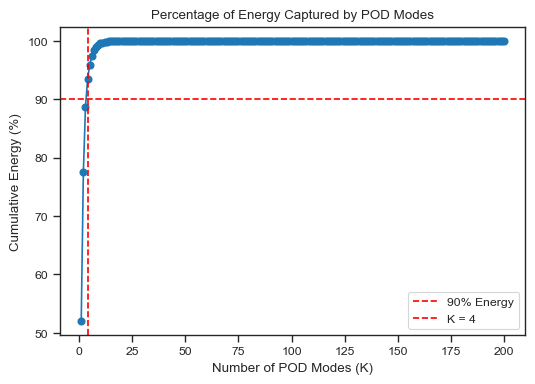

Need 4 POD modes to capture 90% of the energy.


In [9]:
# Your code here (https://predictivesciencelab.github.io/advanced-scientific-machine-learning/reduced_order_modeling/01_svd.html)

# Calculate the energy percentage for each mode
total_energy = np.sum(s**2)
cumulative_energy_percentage = np.cumsum(s**2) / total_energy * 100

# Plot the percentage of energy captured
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(s) + 1), cumulative_energy_percentage, marker='o', linestyle='-')
plt.axhline(y=90, color='r', linestyle='--', label="90% Energy")

K_90 = np.argmax(cumulative_energy_percentage >= 90) + 1
plt.axvline(x=K_90, color='r', linestyle='--', label=f"K = {K_90}")
plt.xlabel("Number of POD Modes (K)")
plt.ylabel("Cumulative Energy (%)")
plt.title("Percentage of Energy Captured by POD Modes")
plt.legend()
plt.grid(False)
plt.show()

print(f"Need {K_90} POD modes to capture 90% of the energy.")

## Part C - Visualize the first two POD modes

Visualize the first two POD modes.
Recall, the POD modes are captured by the columns of the matrix $\mathbf{V}$.
So, you just need to take each of the first two columns of $\mathbf{V}$ and reshape them to the original spatial grid and do a contour plot.

Answer:

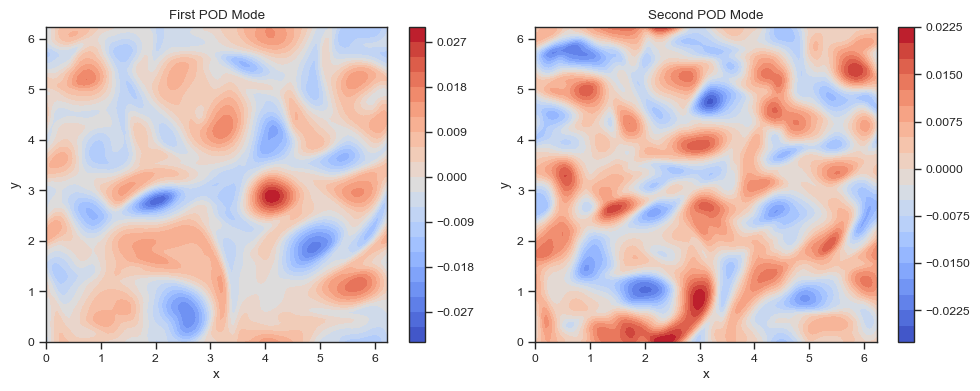

In [10]:
# Your code here

# Reshape the first two POD modes
mode1 = VT[0, :].reshape(128, 128)
mode2 = VT[1, :].reshape(128, 128)

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# First POD mode
plt.subplot(1, 2, 1)
contour1 = plt.contourf(x, y, mode1, cmap='coolwarm', levels=20)
plt.colorbar(contour1)
plt.title('First POD Mode')
plt.xlabel('x')
plt.ylabel('y')

# Second POD mode
plt.subplot(1, 2, 2)
contour2 = plt.contourf(x, y, mode2, cmap='coolwarm', levels=20)
plt.colorbar(contour2)
plt.title('Second POD Mode')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Part D - Principal components or modal coefficients

The principal components or modal coefficients are the projections of the data onto the POD modes.
Using the SVD, we have that the projections are:

$$
\mathbf{Z} = \mathbf{U}\boldsymbol{\Sigma}.
$$

Find that matrix and keep only the columns that correspond to 90% of the energy.

Answer:

In [11]:
# Your code here

# Compute the modal coefficients (PCs)
Z = U @ np.diag(s) 

# Only the first K_90 columns
Z_90 = Z[:, :K_90]  

# Print shape
print(f"Shape of Z: {Z.shape}")  
print(f"Shape of Z_90: {Z_90.shape}")  


Shape of Z: (200, 200)
Shape of Z_90: (200, 4)


## Part E - The modal coefficients are uncorrelated

Verify numerically that the modal coefficients are uncorrelated, i.e., that the empirical mean of the product of the modal coefficients is zero.

*Hint: You won't find exactly zero, but you should find a number that is very close to zero. You can get what you want by looking at the off diagonal of $\mathbf{Z}^T\mathbf{Z}$ and dividing by 200.*

Answer:

Time taken: 0.000104 seconds
Shape of correlation matrix: (4, 4)

Correlation matrix of modal coefficients:
[[ 2.9416997e+05  4.0865918e-03  5.0850939e-02  7.2525279e-03]
 [ 4.0865918e-03  1.4407859e+05 -2.3321874e-02  1.5042085e-03]
 [ 5.0850939e-02 -2.3321874e-02  6.3186359e+04 -1.6810505e-02]
 [ 7.2525279e-03  1.5042085e-03 -1.6810505e-02  2.6739582e+04]]
Off-diagonal elements of correlation matrix:
[[        nan  0.00408659  0.05085094  0.00725253]
 [ 0.00408659         nan -0.02332187  0.00150421]
 [ 0.05085094 -0.02332187         nan -0.0168105 ]
 [ 0.00725253  0.00150421 -0.0168105          nan]]

Maximum absolute off-diagonal correlation: 0.051


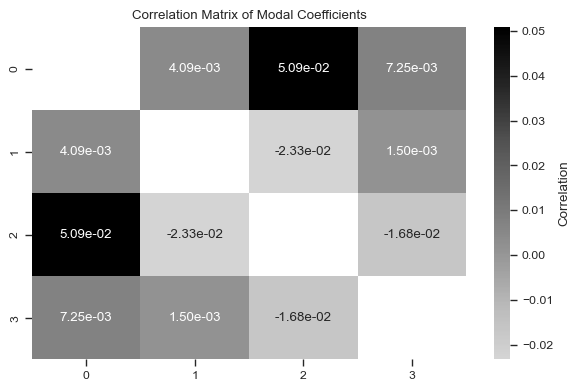

In [12]:
# Your code here
import time
start = time.time()
# Compute the correlation matrix of modal coefficients
# We'll use Z_90 from the previous computation
correlation_matrix = (Z_90.T @ Z_90) / Z_90.shape[0]
end = time.time()
print(f"Time taken: {end - start:.6f} seconds")
print(f"Shape of correlation matrix: {correlation_matrix.shape}")
print("\nCorrelation matrix of modal coefficients:")
print(correlation_matrix)

# Print the off-diagonal elements
print("Off-diagonal elements of correlation matrix:")
np.fill_diagonal(correlation_matrix, np.nan)  
print(correlation_matrix)

# Compute the absolute value of maximum off-diagonal correlation
max_off_diagonal_correlation = np.nanmax(np.abs(correlation_matrix))
print(f"\nMaximum absolute off-diagonal correlation: {max_off_diagonal_correlation:.3f}")

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, cmap='Greys', center=0, 
            annot=True, fmt='.2e', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Modal Coefficients')

plt.tight_layout()
plt.show()

In [13]:
# Your code here
# Compute the correlation matrix of modal coefficients
# We'll use Z_90 from the previous computation
start = time.time()
correlation_matrix = np.einsum('ik,il->kl', Z_90, Z_90) / Z_90.shape[0]
end = time.time()
print(f"Time taken: {end - start:.6f} seconds")
print(f"Shape of correlation matrix: {correlation_matrix.shape}")
print("\nCorrelation matrix of modal coefficients:")
print(correlation_matrix)

# Print the off-diagonal elements
print("Off-diagonal elements of correlation matrix:")
np.fill_diagonal(correlation_matrix, np.nan)  
print(correlation_matrix)


Time taken: 0.000559 seconds
Shape of correlation matrix: (4, 4)

Correlation matrix of modal coefficients:
[[ 2.9416997e+05  4.0865918e-03  5.0850939e-02  7.2525279e-03]
 [ 4.0865918e-03  1.4407859e+05 -2.3321874e-02  1.5042085e-03]
 [ 5.0850939e-02 -2.3321874e-02  6.3186359e+04 -1.6810505e-02]
 [ 7.2525279e-03  1.5042085e-03 -1.6810505e-02  2.6739582e+04]]
Off-diagonal elements of correlation matrix:
[[        nan  0.00408659  0.05085094  0.00725253]
 [ 0.00408659         nan -0.02332187  0.00150421]
 [ 0.05085094 -0.02332187         nan -0.0168105 ]
 [ 0.00725253  0.00150421 -0.0168105          nan]]


If the modal coefficients are uncorrelated, these off-diagonal elements should be exactly or close to zero numerically which is shown here above. Meh eisum here ain't any better!


## Part F - Plot the time evolution of the first two modal coefficients

Plot the time evolution of the first two modal coefficients.

Answer:

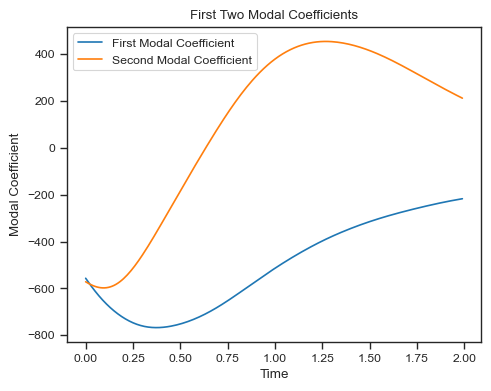

In [14]:
# Your code here
# Plot the time evolution of the first two modal coefficients
plt.figure(figsize=(5, 4))
plt.plot(times, Z_90[:, 0], label='First Modal Coefficient')
plt.plot(times, Z_90[:, 1], label='Second Modal Coefficient')

plt.title('First Two Modal Coefficients')
plt.xlabel('Time')
plt.ylabel('Modal Coefficient')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


## Part G - Reconstruction of the velocity magnitude

Reconstruct the velocity magnitude at times 0, 1, and 2, using the first $K$ POD modes (90\% of the energy).
Compare your reconstructions with the original data.

Answer:

Shape of V_90: (4, 16384)
Reconstructed velocity shape: (200, 16384)
Reshaped reconstructed velocity: (200, 128, 128)


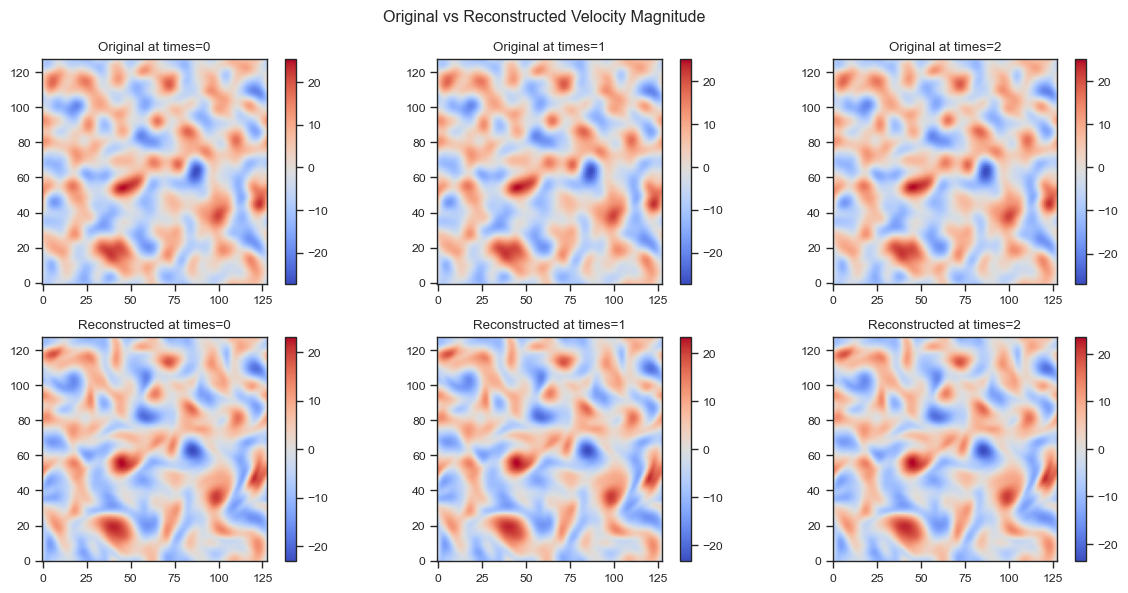

In [15]:
# Your code here

# Select the first K columns of V corresponding to 90% energy
V_90 = VT[:K_90, :]
print(f"Shape of V_90: {V_90.shape}")

# Compute the reconstructed velocity
X_reconstructed = Z_90 @ V_90  
print(f"Reconstructed velocity shape: {X_reconstructed.shape}")

# Reshape the reconstructed data to original shape
X_reconstructed = X_reconstructed.reshape(200, 128, 128)
print(f"Reshaped reconstructed velocity: {X_reconstructed.shape}")

# Plot at times 0, 1, and 2
time_indices = [0, 1, 2]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, t in enumerate(time_indices):
    # Original data
    ax = axes[0, i]
    im = ax.imshow(vel_mag[t], cmap='coolwarm', origin='lower')
    ax.set_title(f"Original at times={t}")
    plt.colorbar(im, ax=ax)

    # Reconstructed data
    ax = axes[1, i]
    im = ax.imshow(X_reconstructed[t], cmap='coolwarm', origin='lower')
    ax.set_title(f"Reconstructed at times={t}")
    plt.colorbar(im, ax=ax)

# Formatting
plt.suptitle("Original vs Reconstructed Velocity Magnitude")
plt.tight_layout()
plt.show()


# Problem 3 - Stochastic model for permeability of oil reservoir

In this problem, we will use the Karhunen-Loève expansion to model the permeability of an oil reservoir. Feel free to use the code provided in the hands-on activities to complete this problem.

The permeability of the soil is one of the largest unknowns in modeling underground flows. Here, you will create a 2D model of permeability that can be used for propagating uncertainties or as a starting point for model calibration. This is the information that is available to you:
+ You need to build a stochastic model for permeability with as low dimensionality as possible.
+ You need to be able to sample random permeability fields from this model.
+ The permeability is strictly positive.
+ The 2D domain you should consider is $[0, 356]\times[0,670]$ (in meters).
+ Our geologist gave us her best estimate about the permeability field. We have put the results for you in a data file and we show you how to load it and plot it below.
+ When asked how sure she is about the prediction, the geologist gave a standard deviation of about 3.2 on the logarithm of the permeability.
+ She also believes that there are two lengthscales: 50 meters and 10 meters.

Answer the following questions.

## Part A - Model the Permeability Field

Write down the mathematical form of the best stochastic model for the permeability you can come up with using the information above. Are you going to use a GP? Are you going to consider a transformed version of the GP? What would the mean be? What would the covariance function be? What would the parameters of the covariance function be?


Answer:

Mathematical Form of the Stochastic Model for Permeability

To model the permeability field in the 2D domain $[0, 356] \times [0, 670]$ (in meters), we can use a Gaussian Process (GP). A GP is a powerful tool for modeling spatial data, and it consists of two main components:

- A mean function, $m(x)$, which gives the expected value of the permeability at any point in the domain.
- A covariance function, $k(x, x')$, which defines how correlated the permeability values are between two points $x$ and $x'$.

The general form of a GP is:

$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$

Where:
- $f(x)$ represents the permeability at location $x$,
- $m(x)$ is the mean function,
- $k(x, x')$ is the covariance function.

The mean permeability field, $m(x)$, is based on the logarithm of the permeability. Let $M(x)$ be the estimated mean permeability, then:

$$
m(x) = \log(M(x))
$$

Where $M(x)$ is the permeability estimate given by the geologist.

The permeability field $k(x)$ is modeled as:

$$
k(x) = \exp(m(x) + \epsilon(x))
$$

Here, $\epsilon(x)$ represents the random variations in the logarithmic permeability, and $\epsilon(x)$ follows a GP with zero mean.

Now, we need to model the covariance. The geologist mentioned two length scales for the permeability field: one of 50 meters and another of 10 meters. So, we combine two different kernels to capture this behavior. 

$$
k(x, x') = \sigma^2 \left( \exp\left(-\frac{|x - x'|^2}{2l_1^2}\right) + \exp\left(-\frac{|x - x'|^2}{2l_2^2}\right) \right)
$$

Where:
- $\sigma^2$ is the signal variance,
- $l_1 = 50 \, \text{m}$ and $l_2 = 10 \, \text{m}$ are the two different length scales,
- $|x - x'|$ is the Euclidean distance between points $x$ and $x'$ in the domain.

Since the permeability field must always be positive (i.e., $k(x) > 0$), we take the logarithm of the permeability field to model it with a GP, which naturally respects the positivity constraint.

Thus, we have:

$$
k(x) = \exp(f(x))
$$

Where $f(x) \sim \mathcal{GP}(m(x), k(x, x'))$ with the covariance function defined above.


- Mean function: $m(x) = \log(M(x))$, which comes from the geologist’s best estimate of the permeability.
- Covariance function parameters:
  - Signal variance, $\sigma^2$,
  - Length scales, $l_1 = 50 \, \text{m}$ and $l_2 = 10 \, \text{m}$ and $\sigma^2 = 3.2^2$




The best model for the permeability field is a Gaussian Process on the logarithm of the permeability. The components of this model are:

1. Mean function: $m(x) = \log(M(x))$,
2. Covariance function: A sum of two squared exponential kernels:

$$
k(x, x') = \sigma^2/2 \left( \exp\left(-\frac{|x - x'|^2}{2l_1^2}\right) + \exp\left(-\frac{|x - x'|^2}{2l_2^2}\right) \right)
$$

3. Transformed field: The permeability field is given by $k(x) = \exp(f(x))$, where $f(x)$ is a GP with the mean and covariance defined above.



## Part B - Perform the Karhunen-Loève Expansion on the Prior

Construct the Karhunen-Loève expansion of the field using the code provided in the hands-on activities. You should: 1) use enough quadrature points so that you get a converged Nyström approximation; 2) use enough terms to cover $95\%$ of the fields energy; 3) Plot the eigenvalues of KLE; 4) Plot the first six eigenfunctions of KLE; 5) Plot six samples of the random field.

Here is the mean field provided by the geologist:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  193k  100  193k    0     0   738k      0 --:--:-- --:--:-- --:--:--  741k


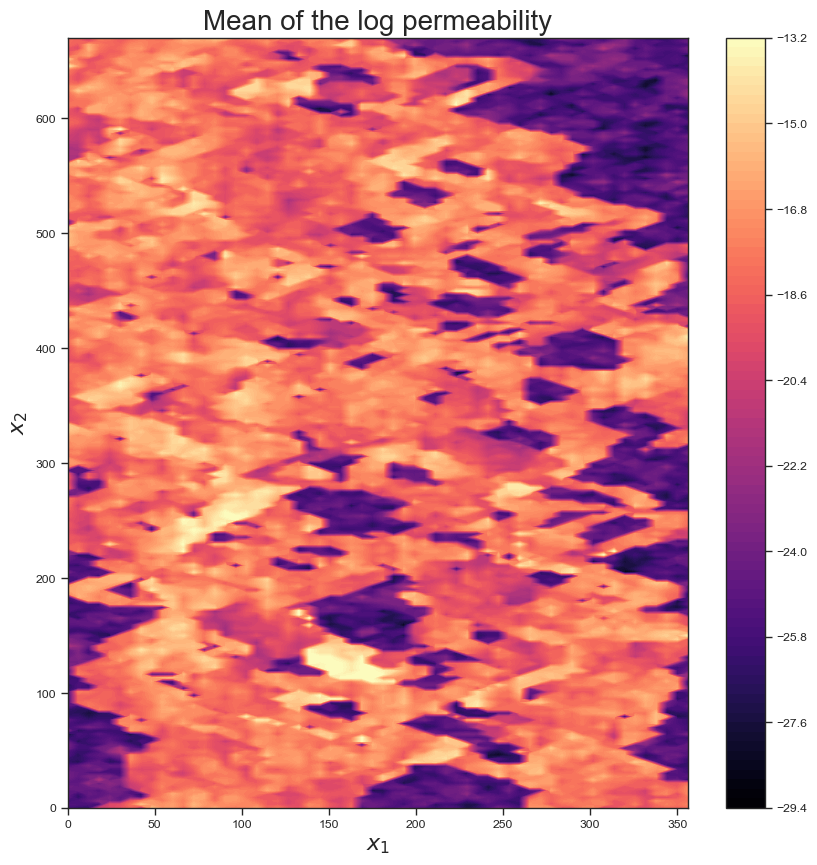

In [16]:
# Download the data 
!curl -O 'https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/homeworks/spe10_permx.dat'

# Import the data
import pandas as pd
import numpy as np
M = pd.read_csv('spe10_permx.dat', delimiter=' ', header=None).loc[:, 1:].values.T

# Visualize the mean field 
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)

fig, ax = plt.subplots(1, figsize = (10, 10))
im=ax.contourf(X1, X2, np.log(M), 100, cmap = 'magma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('$x_1$', fontsize = 16)
ax.set_ylabel('$x_2$', fontsize = 16)
ax.set_title('Mean of the log permeability', fontsize=20);

Answer:

In [17]:
# Your code here

# Load the permeability data
log_M = np.log(M)
print(log_M.shape)

# Domain specifications
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)
# print(X1,x2)

# Prepare coordinates and data
X_all = np.column_stack([X1.flatten(), X2.flatten()])
y_data = log_M.flatten()
# print(f"Shape of X_all: {X_all.shape}")
# print(f"Shape of y_data: {y_data.shape}")
# print(X_all)

# Normalize coordinates to [0,1]
X_normalized = (X_all - X_all.min(axis=0)) / (X_all.max(axis=0) - X_all.min(axis=0))

class KarhunenLoeveExpansion(eqx.Module):
    """
    Karhunen-Loeve Expansion for Gaussian Processes
    Parameters
    ----------
    gp: GaussianProcess
        Gaussian process object
    lambd: jnp.ndarray
        Eigenvalues of the covariance matrix
    v: jnp.ndarray
        Eigenvectors of the covariance matrix
    wq: jnp.ndarray
        Quadrature weights

    Attributes
    ----------
    num_xi: int
        Number of terms in the expansion        
    """ 
    gp: GaussianProcess
    lambd: jnp.ndarray
    v: jnp.ndarray
    wq: jnp.ndarray

    def __init__(self, gp, wq, alpha=0.9):
        Kq = gp.covariance
        B = jnp.einsum('ij,j->ij', Kq, wq)
        lam, v = jax.scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam = lam.at[lam <= 0.].set(0.)
        
        # Keep the eigenvalues with alpha% of the energy (in our case 95%)
        energy = jnp.cumsum(lam) / jnp.sum(lam)
        i_end = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        
        self.gp = gp
        self.lambd = lam
        self.v = v
        self.wq = wq

    @property
    def num_xi(self):
        """Number of terms in the expansion"""
        return self.lambd.shape[0]

    def eval_phi(self, x):
        Kc = self.gp.kernel(x, self.gp.X)
        phi = jnp.einsum("rj,i,ji,j->ri", Kc, 1/self.lambd, self.v, self.wq**0.5, optimize="dp")
        return phi

    def __call__(self, x, xi):
        phi = self.eval_phi(x)
        return vmap(self.gp.mean_function)(x) + jnp.dot(phi, xi * self.lambd**0.5)

class PermeabilityModel:
    def __init__(self, 
                 domain_x, 
                 domain_y, 
                 log_std_dev, 
                 lengthscales,
                 alpha,
                 nq,
                 mean_field):
        """
        Initialize the stochastic permeability model
        Parameters:
        -----------
        domain_x : tuple
            Domain boundaries in x-direction
        domain_y : tuple
            Domain boundaries in y-direction
        log_std_dev : float
            Log standard deviation for permeability
        lengthscales : tuple
            Correlation lengthscales in x and y directions
        alpha : float
            Percentage of energy to retain in KLE
        nq : int
            Number of quadrature points in each dimension
        mean_field : array-like, 
            Mean field for the permeability
        -----------
        """
        self.domain_x = domain_x
        self.domain_y = domain_y
        self.log_std_dev = log_std_dev
        self.lengthscales = lengthscales
        self.nq = nq
        self.quadrature_points = nq * nq # Total number of quadrature points
        self.mean_field = jnp.array(mean_field) if mean_field is not None else None
        
        # Create coordinate grid
        nx, ny = 60, 220 
        x = np.linspace(domain_x[0], domain_x[1], nx)
        y = np.linspace(domain_y[0], domain_y[1], ny)
        self.X1, self.X2 = np.meshgrid(x, y)
        
        # Flatten coordinates
        self.X_all = np.column_stack([self.X1.flatten(), self.X2.flatten()])
           
        # Normalize coordinates
        self.X_normalized = (self.X_all - self.X_all.min(axis=0)) / (self.X_all.max(axis=0) - self.X_all.min(axis=0))
        
        # Create composite kernel
        self.kernel = self._create_composite_kernel()
        
        # Build KLE
        self.kle = self._build_kle(alpha)
    
    def _create_composite_kernel(self):
        """Create a composite kernel with specified lengthscales"""
        # Normalize lengthscales to [0,1]
        l1_norm = self.lengthscales[0] / (self.domain_x[1] - self.domain_x[0])
        l2_norm = self.lengthscales[1] / (self.domain_y[1] - self.domain_y[0])
        
        # Kernels for each lengthscale
        k1 = kernels.ExpSquared(scale=l1_norm)
        k2 = kernels.ExpSquared(scale=l2_norm)
        # Combine kernels
        return (3/2)**2 * Sum(k1, k2)
    
    def _build_kle(self, alpha=0.95):
        """Build Karhunen-Loève Expansion"""
        # Convert to JAX arrays
        X_jax = jnp.array(self.X_normalized)
        
        # Generate quadrature points
        # nq = int(jnp.sqrt(self.quadrature_points)
        x = jnp.linspace(0, 1, self.nq)
        X1, X2 = jnp.meshgrid(x, x)
        Xq = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
        wq = jnp.ones((self.nq**2,))/self.nq**2
        
        # Build Gaussian Process
        gp = GaussianProcess(self.kernel, Xq, diag=self.log_std_dev**2)
        
        return KarhunenLoeveExpansion(gp, wq, alpha)
    
    def sample(self, key, n_samples=1):
        """
        Generate random permeability fields
        """
        # Prepare coordinate array
        X_all = jnp.array(self.X_normalized)
        
        # Generate samples
        samples = []
        for _ in range(n_samples):
            key, subkey = jrandom.split(key)
            # Generate random xi
            xi = jrandom.normal(subkey, shape=(self.kle.num_xi,))
            
            # Evaluate the random field and exponentiate
            sample = jnp.exp(self.kle(X_all, xi)).reshape(self.X1.shape)
            samples.append(sample)
        
        return jnp.array(samples)

(220, 60)


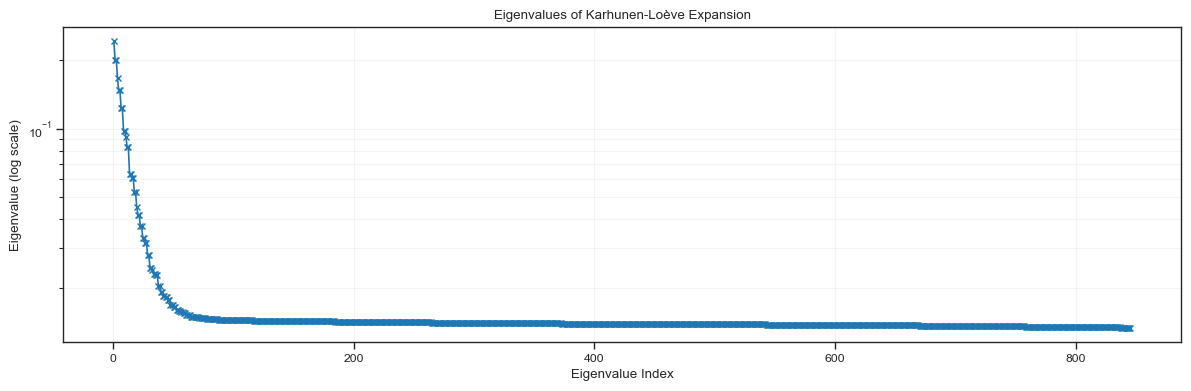

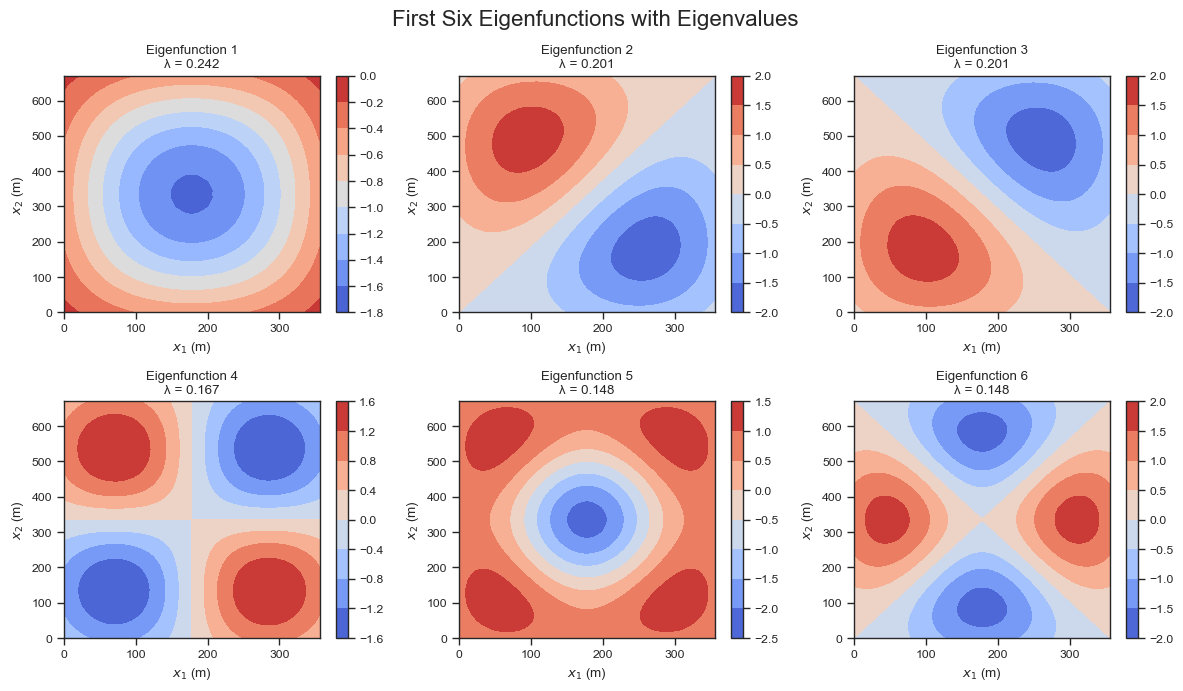

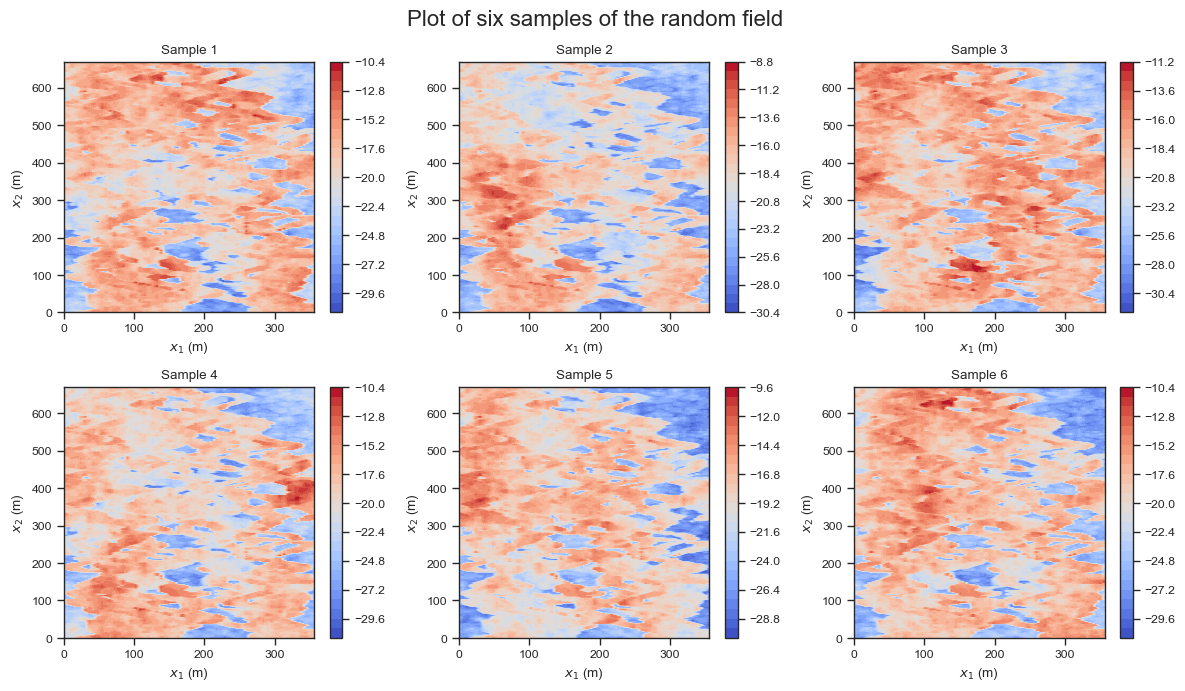

Number of KLE terms: 845


In [18]:
# Plottoing functions
def plot_eigenvalues(kle):
    """
    Plot eigenvalues of the Karhunen-Loève Expansion
    
    Parameters:
    -----------
    kle : KarhunenLoeveExpansion
        The KLE object
    """
    plt.figure(figsize=(12, 4))
    plt.semilogy(range(1, len(kle.lambd) + 1), kle.lambd, 'x-')
    plt.title('Eigenvalues of Karhunen-Loève Expansion')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue (log scale)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_eigenfunctions(perm_model, num_eigenfunctions):
    """
    Plot the first few eigenfunctions with eigenvalue annotations.
    
    Parameters:
    -----------
    perm_model : PermeabilityModel
        The permeability model
    """
    # Prepare coordinate array
    X_all = jnp.array(perm_model.X_normalized)
    
    # Evaluate eigenfunctions
    Phi = perm_model.kle.eval_phi(X_all)
    
    # Plot first 6 eigenfunctions
    fig, axs = plt.subplots(2, 3, figsize=(12, 7))
    fig.suptitle('First Six Eigenfunctions with Eigenvalues', fontsize=16)
    
    for i in range(num_eigenfunctions):
        row, col = i // 3, i % 3
        im = axs[row, col].contourf(perm_model.X1, perm_model.X2, 
                                    Phi[:, i].reshape(perm_model.X1.shape), 
                                    cmap='coolwarm')
        lambd_val = float(perm_model.kle.lambd[i])
        axs[row, col].set_title(f'Eigenfunction {i+1}\nλ = {lambd_val:.3f}')
        axs[row, col].set_xlabel('$x_1$ (m)')
        axs[row, col].set_ylabel('$x_2$ (m)')
        plt.colorbar(im, ax=axs[row, col])
    
    plt.tight_layout()
    plt.show()

def plot_random_samples_logK(perm_model, key, n_samples=6):
    """
    Plot samples of log(K) from the prior model
    """
    X_all = jnp.array(perm_model.X_normalized)
    logK_mean_flat = perm_model.mean_field.flatten()
    samples = []
    
    for _ in range(n_samples):
        key, subkey = jrandom.split(key)
        xi = jrandom.normal(subkey, shape=(perm_model.kle.num_xi,))
        # logK = perm_model.kle(X_all, xi).reshape(perm_model.X1.shape)
        logK = (perm_model.kle(X_all, xi) + logK_mean_flat).reshape(perm_model.X1.shape)

        samples.append(logK)
    
    # Plot
    fig, axs = plt.subplots(2, 3, figsize=(12, 7))
    fig.suptitle('Plot of six samples of the random field', fontsize=16)
    
    for i in range(n_samples):
        row, col = i // 3, i % 3
        im = axs[row, col].contourf(perm_model.X1, perm_model.X2,
                                    samples[i],
                                    cmap='coolwarm', levels=30)
        axs[row, col].set_title(f'Sample {i+1}')
        axs[row, col].set_xlabel('$x_1$ (m)')
        axs[row, col].set_ylabel('$x_2$ (m)')
        plt.colorbar(im, ax=axs[row, col])
    
    plt.tight_layout()
    plt.show()

# Demonstration
key = jrandom.PRNGKey(42)

# Create the permeability model
perm_model= PermeabilityModel( 
                 domain_x=(0, 356), 
                 domain_y=(0, 670), 
                 log_std_dev=3.2, 
                 lengthscales=(50, 10),
                 alpha=0.95,
                 nq=30,
                 mean_field=log_M)


# Plot eigenvalues
plot_eigenvalues(perm_model.kle)

# Plot eigenfunctions
plot_eigenfunctions(perm_model, num_eigenfunctions= 6)

# Plot log(K) samples
plot_random_samples_logK(perm_model, key)

print(f"Number of KLE terms: {perm_model.kle.num_xi}")

## Part C - Condition the Prior on the Observations

You sent a crew to go and make some measurements of the permeability. Repeate everything you did in part B making use of the new data:
 

|$x_1$ |$x_2$ | $\log K(x_1, x_2)$ |
|------|------|--------------------|
|100.  |200.  | -13.2              |
|300.  |500.  | -25.3              |

Hint: You will have to condition your prior probability measure on the observations and work with the posterior mean and posterior covariance function.

Answer:

In [19]:
# Observations
obs_X = jnp.array([
    [100.0, 200.0],
    [300.0, 500.0]
])
obs_y = jnp.array([-13.2, -25.3])

# Normalize observation points
X_min = perm_model.X_all.min(axis=0)
X_max = perm_model.X_all.max(axis=0)
obs_X_scaled = (obs_X - X_min) / (X_max - X_min)

In [ ]:
# Build Posterior GP
class PosteriorGP:
    """"
    Posterior Gaussian Process 
    """
    def __init__(self, prior_gp, obs_X, obs_y):
        self.kernel = prior_gp.kernel
        self.X_train = prior_gp.X
        self.obs_X = obs_X
        self.obs_y = obs_y
        self.noise = 1e-6

        K_obs = self.kernel(obs_X, obs_X) + self.noise * jnp.eye(len(obs_X))
        K_obs_train = self.kernel(obs_X, self.X_train)
        K_train_train = prior_gp.covariance

        mean_func = vmap(lambda x: 0.0)
        mu_X = mean_func(self.X_train)
        mu_x = mean_func(obs_X)

        Kinv = jnp.linalg.inv(K_obs)
        self.post_mean = mu_X + K_obs_train.T @ Kinv @ (obs_y - mu_x)
        self.post_cov = K_train_train - K_obs_train.T @ Kinv @ K_obs_train
        self.kernel = prior_gp.kernel  

    def sample(self, key, x_eval, n_samples, mean_field):
        K_eval_obs = self.kernel(x_eval, self.obs_X)
        K_obs_obs = self.kernel(self.obs_X, self.obs_X) + self.noise * jnp.eye(len(self.obs_X))
        mean_func = vmap(lambda x: 0.0)

        Kinv = jnp.linalg.inv(K_obs_obs)
        mu_post = mean_func(x_eval) + K_eval_obs @ Kinv @ (self.obs_y - mean_func(self.obs_X))
        cov_post = self.kernel(x_eval, x_eval) - K_eval_obs @ Kinv @ K_eval_obs.T
        L = jnp.linalg.cholesky(cov_post + 1e-6 * jnp.eye(cov_post.shape[0]))
        samples = []
        for _ in range(n_samples):
            key, subkey = jrandom.split(key)
            z = jrandom.normal(subkey, shape=(cov_post.shape[0],))
            sample_logK = mu_post + L @ z
            sample_logK_with_mean = sample_logK + mean_field.flatten()
            # sample_K = jnp.exp(sample_logK_with_mean).reshape((220, 60))
            # samples.append(jnp.exp(sample_logK_with_mean).reshape((220, 60)))
            samples.append(sample_logK_with_mean.reshape((220, 60)))
        return samples

# Instantiate Posterior GP
posterior_gp = PosteriorGP(perm_model.kle.gp, obs_X_scaled, obs_y)

# Posterior GP 
class PosteriorModel:
    def __init__(self, X_all, X1, X2, posterior_gp, x_eval, alpha=0.95):
        self.X1 = X1
        self.X2 = X2
        self.X_all = X_all
        self.X_normalized = x_eval

        class GPStub:
            def __init__(self, kernel, X, cov):
                self.kernel = kernel
                self.X = X
                self.covariance = cov
                self.mean_function = lambda x: 0.0

        cov = posterior_gp.kernel(x_eval, x_eval)
        gp_stub = GPStub(posterior_gp.kernel, x_eval, cov)
        wq = jnp.ones((x_eval.shape[0],)) / x_eval.shape[0]
        self.kle = KarhunenLoeveExpansion(gp_stub, wq, alpha=alpha)


In [21]:
# Build Posterior Model
x_eval = jnp.array(perm_model.X_normalized)
posterior_model = PosteriorModel(
    X_all=perm_model.X_all,
    X1=perm_model.X1,
    X2=perm_model.X2,
    posterior_gp=posterior_gp,
    x_eval=x_eval
)

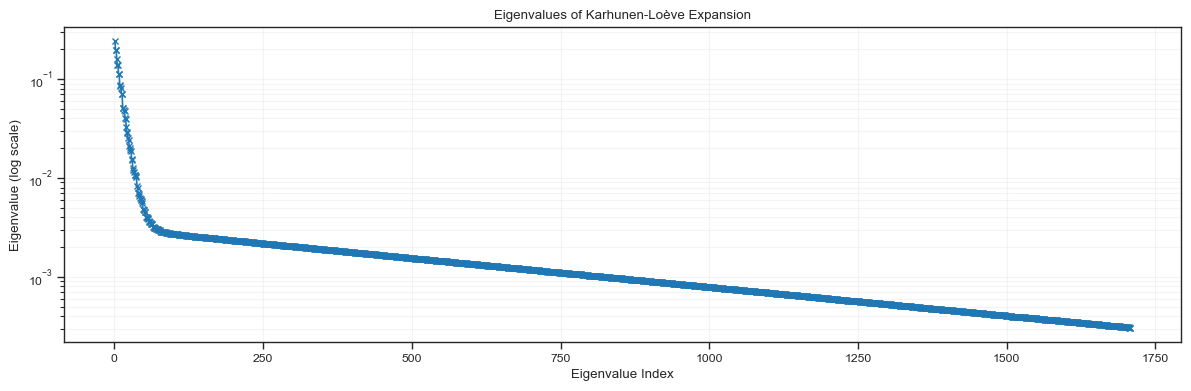

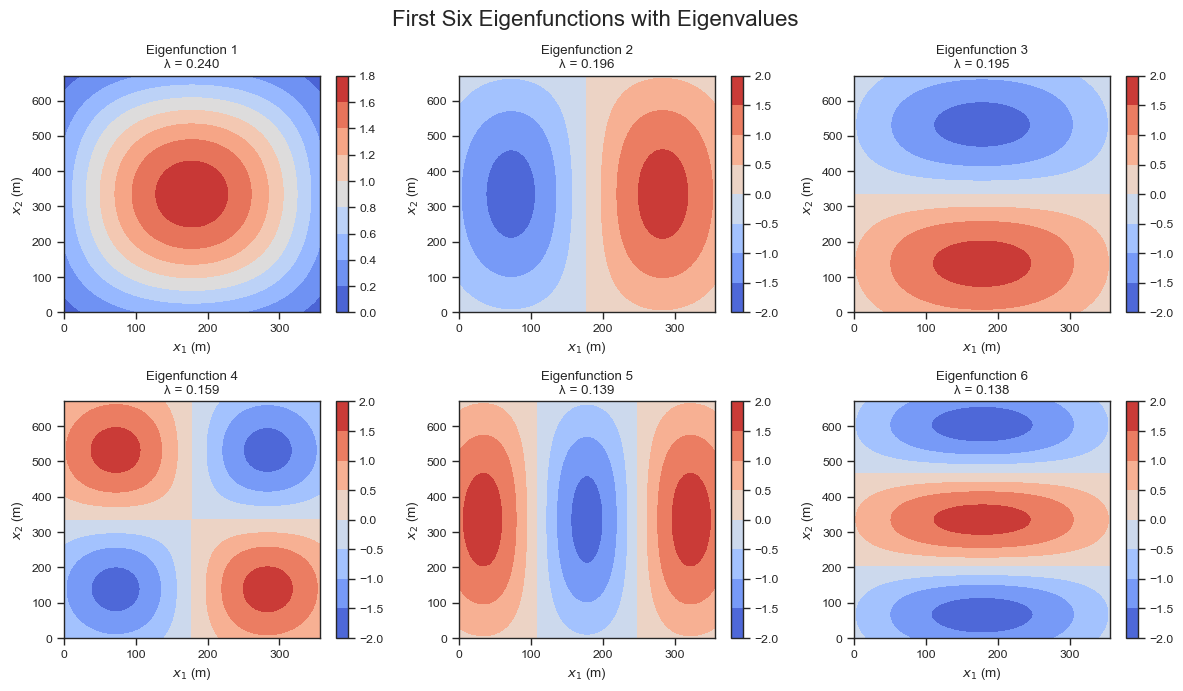

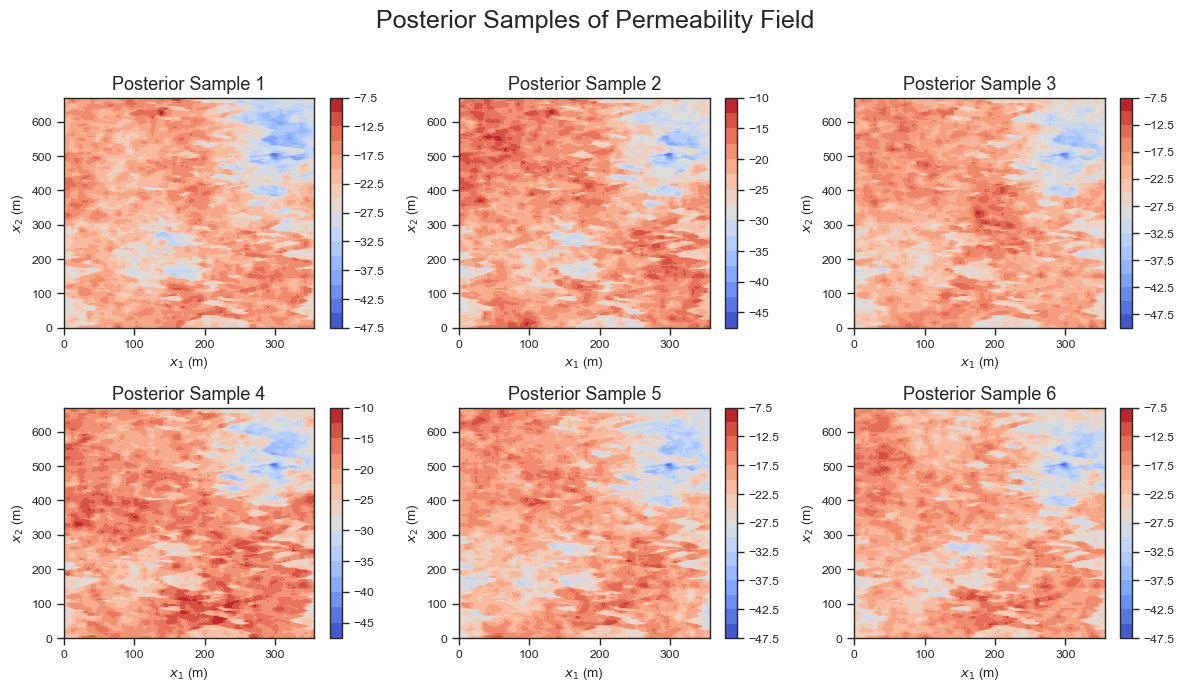

In [22]:
# Plot Eigenvalues
plot_eigenvalues(posterior_model.kle)

# Plot Eigenfunctions
plot_eigenfunctions(posterior_model, num_eigenfunctions=6)

# Draw Posterior Samples
samples = posterior_gp.sample(key, x_eval=x_eval, n_samples=6, mean_field=perm_model.mean_field)

# Plot Posterior Samples
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('Posterior Samples of Permeability Field', fontsize=18)
axs = axs.flatten()

for i in range(len(samples)):
    ax = axs[i]
    im = ax.contourf(perm_model.X1, perm_model.X2, samples[i], levels=15, cmap='coolwarm')
    ax.set_title(f'Posterior Sample {i+1}', fontsize=13)
    ax.set_xlabel('$x_1$ (m)')
    ax.set_ylabel('$x_2$ (m)')
    plt.colorbar(im, ax=ax)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Problem 4: Operator learning for Darcy flow

Darcy flow refers to the flow of a fluid through a porous medium under a pressure gradient.
For some physical domain $\Omega$, the governing equation can be written as:

$$
\nabla \cdot \left( K \nabla p \right) = f,
$$

where $K: \Omega \to \mathbb{R}_+$ is the permeability field and $p: \Omega \to \mathbb{R}_+$ is the pressure field. 
For a known boundary condition and source term $f$ , we want to learn the operator $K \mapsto p$.


## Part A - Train a Fourier Neural Operator

We will use simulation data from the [examples in the `neuraloperator` library documentation](https://neuraloperator.github.io/dev/auto_examples/index.html).
Let's say the simulation inputs $x$ are related to the permeability $K$ at all spatial locations $r \in \Omega$ by
$$
K(r) = \begin{cases} k_1 & \text{if } x(r) = 0 \\ k_2 & \text{if } x(r) = 1 \end{cases}
$$ 

for some $k_0$ and $k_1$. Also, suppose the simulation output $y$ is related to the pressure $p$ by
$$
y(r) = p(r) - p_0
$$
for some $p_0$. From here on out, we can just work with $x$ and $y$.

Okay, let's import the data:

In [23]:
%pip install -q neuraloperator

import urllib.request
import os
from neuralop.data.datasets import load_darcy_flow_small

def download(
    url : str,
    local_filename : str = None
):
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

base_url = 'https://www.github.com/neuraloperator/neuraloperator/raw/refs/heads/main/neuralop/data/datasets/data/'
download(os.path.join(base_url, 'darcy_test_32.pt'))
download(os.path.join(base_url, 'darcy_test_16.pt'))
download(os.path.join(base_url, 'darcy_train_16.pt'))

train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        data_root='./',
)

device = 'cpu'
data_processor = data_processor.to(device)

Note: you may need to restart the kernel to use updated packages.
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


We have created dataloaders for 3 different datasets:
- a low-resolution (16x16) training set
- a low-resolution test set
- a higher-resolution (32x32) test set

Let's extract the data arrays:

In [24]:
# Code modified from https://neuraloperator.github.io/dev/auto_examples/models/plot_FNO_darcy.html#sphx-glr-auto-examples-models-plot-fno-darcy-py

# Training data
train_samples = train_loader.dataset
train_x = data_processor.preprocess(train_samples[:], batched=False)['x']
train_y = data_processor.preprocess(train_samples[:], batched=False)['y']

# Low-resolution test data
test_samples_16 = test_loaders[16].dataset
test_x_16 = data_processor.preprocess(test_samples_16[:], batched=False)['x']
test_y_16 = data_processor.preprocess(test_samples_16[:], batched=False)['y']

# High-resolution test data
test_samples_32 = test_loaders[32].dataset
test_x_32 = data_processor.preprocess(test_samples_32[:], batched=False)['x']
test_y_32 = data_processor.preprocess(test_samples_32[:], batched=False)['y']

And let's plot a few samples from the training data:

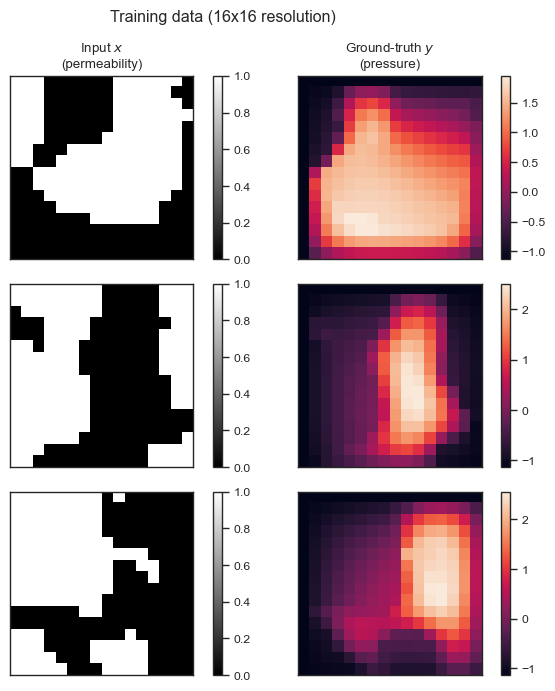

In [25]:
fig = plt.figure(figsize=(7, 7), tight_layout=True)
for index in range(3):
    x = train_x[index]
    y = train_y[index]

    ax = fig.add_subplot(3, 2, index*2 + 1)
    p = ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input $x$\n(permeability)')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    fig.colorbar(p, ax=ax)

    ax = fig.add_subplot(3, 2, index*2 + 2)
    p = ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth $y$\n(pressure)')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    fig.colorbar(p, ax=ax)

fig.suptitle('Training data (16x16 resolution)');

Now, do the following:
- Train a Fourier Neural Operator (FNO) to approximate the Darcy flow operator $x \mapsto y$ using the training data. You may either use the PyTorch library `neuraloperator` or implement your own FNO in JAX. 
- Plot the convergence of the L2 error on the train and test sets as a function of training iterations.
- Plot the ground truth vs. the model prediction for a few samples from each test sets.

Note: You may reuse external code as a starting point (like the example notebooks in the `neuraloperator` documentation). If you do, be sure to state so!

Answer:


In [26]:
print("shape of train_x", train_x.shape)
print("shape of train_y", train_y.shape)
print("shape of test_x_16", test_x_16.shape)
print("shape of test_y_16", test_y_16.shape)
print("shape of test_x_32", test_x_32.shape)
print("shape of test_y_32", test_y_32.shape)

shape of train_x torch.Size([1000, 1, 16, 16])
shape of train_y torch.Size([1000, 1, 16, 16])
shape of test_x_16 torch.Size([50, 1, 16, 16])
shape of test_y_16 torch.Size([50, 1, 16, 16])
shape of test_x_32 torch.Size([50, 1, 32, 32])
shape of test_y_32 torch.Size([50, 1, 32, 32])


In [27]:
# Model hyperparameters
# Model setup
model = FNO(n_modes=(16, 16),
            in_channels=1, 
            out_channels=1,
            hidden_channels=32, 
            projection_channel_ratio=2)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [28]:
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)


In [29]:
def eval_l2(model, data_loader, l2loss, device, data_processor):
    model.eval()
    total_error = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            # batch = data_processor.preprocess(batch)
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            pred = model(x)
            error = l2loss(pred, y, keep_batch=True)
            total_error += error.sum().item()
            num_samples += error.numel()

    return total_error / num_samples  # Mean L2 error

In [30]:
# Losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [31]:
# Logging
train_l2_list = []
test_l2_list = []
test_l2_32_list = []

# Training loop
for epoch in range(30):
    
    total_loss = 0
    for batch in train_loader:
        model.train()

        x = batch['x'].to(device)
        y = batch['y'].to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = train_loss(pred, y)
        loss.backward()       
        # scheduler.step()
        # Gradient clipping to prevent exploding gradients at epoch 20
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()       
        total_loss += loss.item()

    l2_train = eval_l2(model, train_loader, l2loss, device=device, data_processor=data_processor)
    train_l2_list.append(l2_train)

    # Evaluate test L2 on 16x16 and 32x32
    l2_test = eval_l2(model, test_loaders[16], l2loss, device=device, data_processor=data_processor)
    test_l2_list.append(l2_test)

    l2_test_32 = eval_l2(model, test_loaders[32], l2loss, device=device, data_processor=data_processor)
    test_l2_32_list.append(l2_test_32)
    scheduler.step(l2_test)
    
    print(f"[Epoch: {epoch}] Train L2: {l2_train:.4f}, Test L2 (16x16): {l2_test:.4f}, Test L2 (32x32): {l2_test_32:.4f}")
    
    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch}: LR = {param_group['lr']:.2e}")


[Epoch: 0] Train L2: 15.9507, Test L2 (16x16): 12.9841, Test L2 (32x32): 13.2311
Epoch 0: LR = 1.00e-03
[Epoch: 1] Train L2: 9.1293, Test L2 (16x16): 7.8189, Test L2 (32x32): 7.8830
Epoch 1: LR = 1.00e-03
[Epoch: 2] Train L2: 7.3877, Test L2 (16x16): 6.3498, Test L2 (32x32): 6.7504
Epoch 2: LR = 1.00e-03
[Epoch: 3] Train L2: 6.4872, Test L2 (16x16): 5.6213, Test L2 (32x32): 6.2129
Epoch 3: LR = 1.00e-03
[Epoch: 4] Train L2: 5.9111, Test L2 (16x16): 5.0915, Test L2 (32x32): 5.8658
Epoch 4: LR = 1.00e-03
[Epoch: 5] Train L2: 5.3975, Test L2 (16x16): 4.6027, Test L2 (32x32): 5.4772
Epoch 5: LR = 1.00e-03
[Epoch: 6] Train L2: 4.8340, Test L2 (16x16): 4.0695, Test L2 (32x32): 5.0748
Epoch 6: LR = 1.00e-03
[Epoch: 7] Train L2: 4.5792, Test L2 (16x16): 3.7443, Test L2 (32x32): 4.8307
Epoch 7: LR = 1.00e-03
[Epoch: 8] Train L2: 4.3414, Test L2 (16x16): 3.5404, Test L2 (32x32): 4.6065
Epoch 8: LR = 1.00e-03
[Epoch: 9] Train L2: 4.2040, Test L2 (16x16): 3.4315, Test L2 (32x32): 4.4890
Epoch 9: L

In [32]:
print(f'train_l2_list: {train_l2_list}') # mean L2 error on training set per epoch
print(f'test_l2_list: {test_l2_list}') # mean L2 error on 16x16 test set per epoch
print(f'test_l2_32_list: {test_l2_32_list}') # mean L2 error on 32x32 test set per epoch

train_l2_list: [15.950748831033707, 9.129316315054893, 7.387666717171669, 6.487159743905067, 5.911120221018791, 5.3974644765257835, 4.833980195224285, 4.579247258603573, 4.341379798948765, 4.204034686088562, 4.079000562429428, 3.9691976569592953, 3.8705055192112923, 3.7771254554390907, 3.6861991360783577, 3.599663143977523, 3.520875534042716, 3.452874604612589, 3.4040715601295233, 3.4200853388756514, 3.795471653342247, 3.090023025870323, 3.2303871251642704, 3.021218027919531, 2.8753719236701727, 2.883607942610979, 3.3539221063256264, 4.828354600816965, 2.7473460733890533, 2.676178026944399]
test_l2_list: [12.984095096588135, 7.818907737731934, 6.3497514724731445, 5.621341109275818, 5.09149694442749, 4.602718114852905, 4.06951367855072, 3.7443121671676636, 3.540436267852783, 3.431488037109375, 3.361812710762024, 3.3069915771484375, 3.2610405683517456, 3.2181177139282227, 3.177222490310669, 3.141878128051758, 3.115505337715149, 3.0997567176818848, 3.0990004539489746, 3.1425132751464844, 

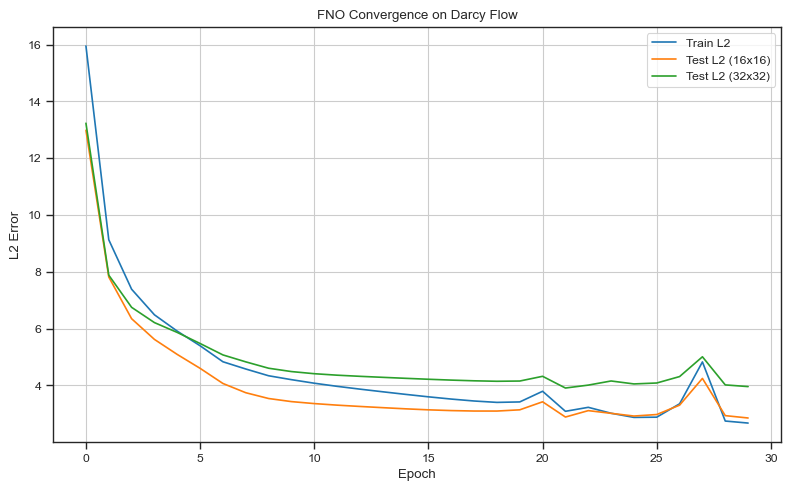

In [33]:
# Plot the L2 errors
plt.figure(figsize=(8, 5))
plt.plot(train_l2_list, label='Train L2')
plt.plot(test_l2_list, label='Test L2 (16x16)')
plt.plot(test_l2_32_list, label='Test L2 (32x32)')
plt.xlabel('Epoch')
plt.ylabel('L2 Error')
plt.title('FNO Convergence on Darcy Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


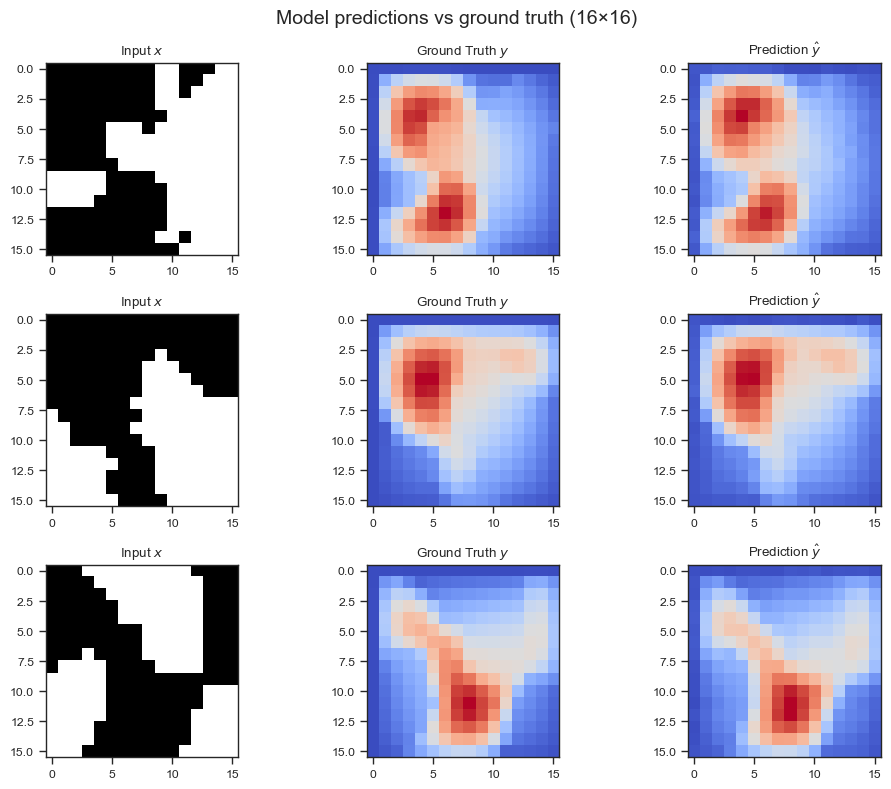

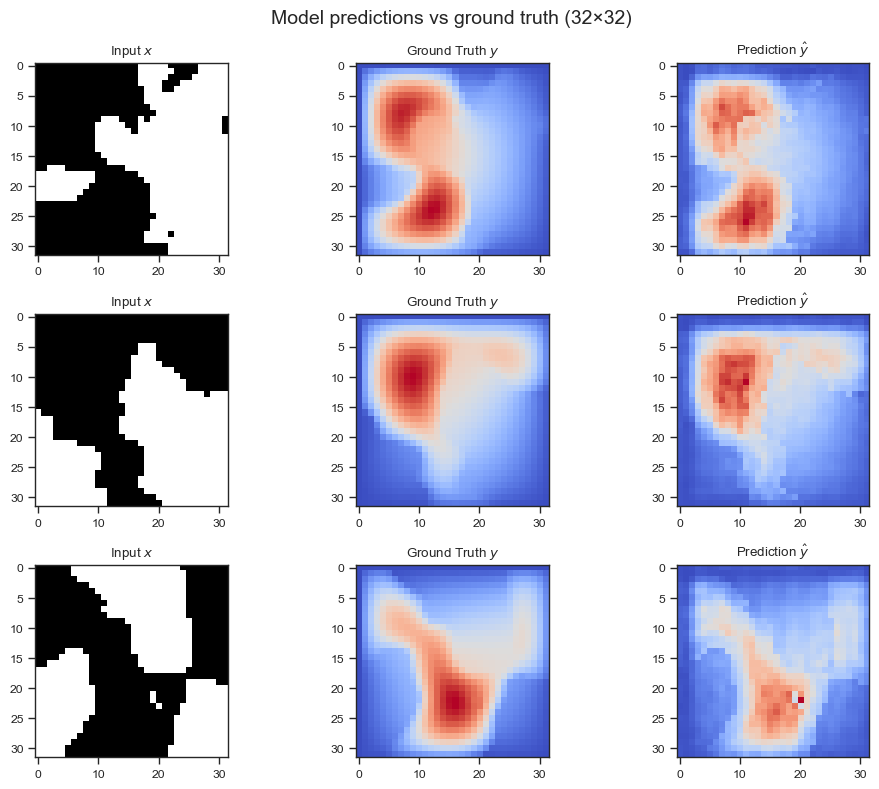

In [34]:
test_samples_16 = test_loaders[16].dataset

fig = plt.figure(figsize=(10, 8))
for idx in range(3):
    data = test_samples_16[idx]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    pred = model(x.unsqueeze(0)).squeeze(0).detach()

    # Input
    ax = fig.add_subplot(3, 3, idx * 3 + 1)

    ax.imshow(x.squeeze().cpu(), cmap='gray')
    ax.set_title('Input $x$')
    ax.axis('on')

    # Ground Truth
    ax = fig.add_subplot(3, 3, idx * 3 + 2)
    ax.imshow(y.squeeze().cpu(), cmap='coolwarm')

    ax.set_title('Ground Truth $y$')
    ax.axis('on')

    # Prediction
    ax = fig.add_subplot(3, 3, idx * 3 + 3)

    ax.imshow(pred.squeeze().cpu(), cmap='coolwarm')
    ax.set_title('Prediction $\hat{y}$')
    ax.axis('on')

fig.suptitle('Model predictions vs ground truth (16×16)', fontsize=14)
plt.tight_layout()
plt.show()


test_samples_32 = test_loaders[32].dataset

fig = plt.figure(figsize=(10, 8))
for idx in range(3):
    data = test_samples_32[idx]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    pred = model(x.unsqueeze(0)).squeeze(0).detach()

    # Input
    ax = fig.add_subplot(3, 3, idx * 3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    ax.set_title('Input $x$')
    ax.axis('on')

    # Ground Truth
    ax = fig.add_subplot(3, 3, idx * 3 + 2)

    ax.imshow(y.squeeze().cpu(), cmap='coolwarm')
    ax.set_title('Ground Truth $y$')
    ax.axis('on')

    # Prediction
    ax = fig.add_subplot(3, 3, idx * 3 + 3)
    ax.imshow(pred[0].cpu(), cmap='coolwarm')
    ax.set_title('Prediction $\hat{y}$')
    ax.axis('on')

fig.suptitle('Model predictions vs ground truth (32×32)', fontsize=14)
plt.tight_layout()
plt.show()


## Part B - Propagate uncertainty through the Darcy flow operator

Suppose you have a noisy measurement of the permeability field $x$ on a 24x24 grid:

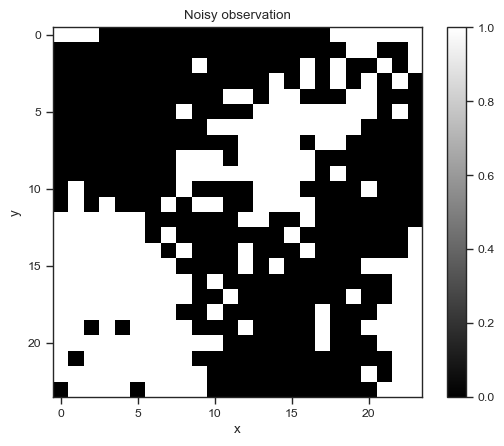

In [35]:
import numpy as np

# Import the noisy observation
download('https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/data/darcy_flow/obs_24x24.npy')
obs = np.load('obs_24x24.npy')

fig, ax = plt.subplots()
p = ax.imshow(obs, cmap='gray')
fig.colorbar(p, ax=ax)
ax.set_title('Noisy observation')
ax.set_xlabel('x')
ax.set_ylabel('y');

We expect the true permeability field to be smoother than this.
So let's create a Gaussian process and condition it on the observation.

(Note that we're handpicking the lengthscale to reflect how smooth we expect $x$ to be. We are also fixing the noise level.)

In [36]:
from jax import vmap
import jax.random as jr
import jax.numpy as jnp
import numpy as np
from tinygp import GaussianProcess, kernels

res = (24, 24)

# Transform the observation so that each pixel is either positive or negative.
obs_transformed = np.where(obs == 1.0, 0.5, -0.5)

# Create the grid
X = np.stack(np.meshgrid(np.linspace(0, 1, res[0]), np.linspace(0, 1, res[1])), axis=-1).reshape(-1, 2)

# Create the Gaussian process
k = kernels.ExpSquared(scale=0.2)  # Handpick the lengthscale
gp = GaussianProcess(k, X, diag=0.5)

# Condition the Gaussian process on the observation
_, cond_gp = gp.condition(obs_transformed.flatten())

# Sample from the conditioned Gaussian process
def sample_x(key):
    # Sample
    z = cond_gp.sample(key)

    # Transform to {0, 1} space
    return jnp.where(z > 0.0, 1.0, 0.0).reshape(res)

Okay, we now have a way to sample permeability fields (evaluated on the 24x24 grid).
Here is how to take a sample:

In [37]:
sample_x(key)

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 

Let's plot a few samples of the smoothed permeability field:

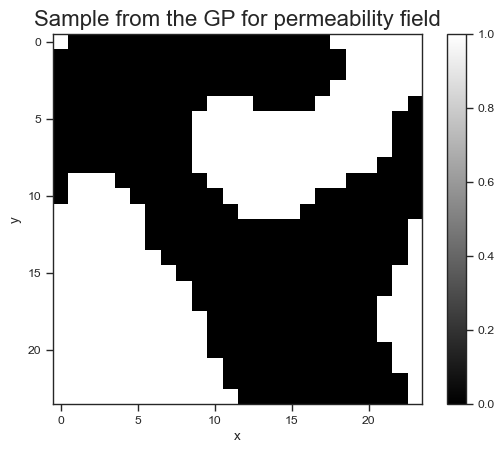

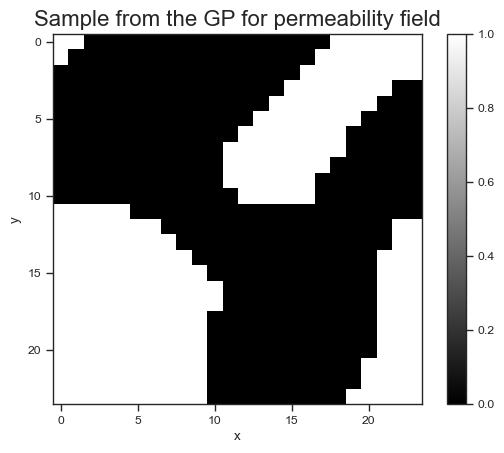

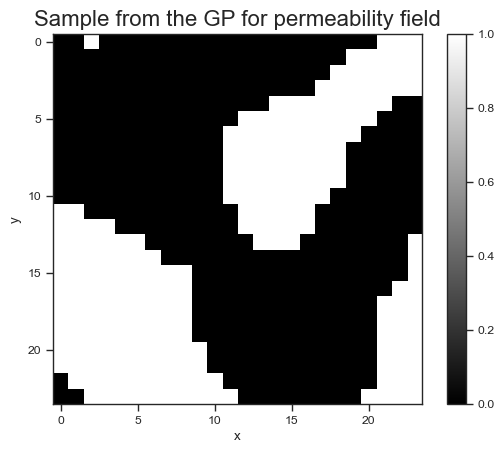

In [38]:
# Collect samples
N = 3
key, subkey = jr.split(key)
keys = jr.split(subkey, N)
samples = vmap(sample_x)(keys)

# Plot
for i in range(N):
    fig, ax = plt.subplots()
    p = ax.imshow(samples[i], cmap='gray')
    fig.colorbar(p, ax=ax)
    ax.set_title('Sample from the GP for permeability field', fontsize=16)
    ax.set_xlabel('x')
    ax.set_ylabel('y');

Okay, we have now implemented a random field that captures our uncertainty about the permeability field $x$.
Let's propagate this uncertainty through the Darcy flow operator you learned in part A.
Do the following:
- Generate 1,000 samples of permeability fields (using the function `sample_x`).
- Evaluate your trained FNO on each of these samples to get 1,000 predicted pressure fields.
- Visualize:
    1. Plot a few samples of the pressure fields.
    2. Make a histogram of the following quantities:
        - The mean predicted pressure (over all pixels), i.e., 
        $$
        \text{mean}[p] = \int_\Omega p(r) dr \approx \frac{1}{24 \times 24} \sum_{i,j} p_{i,j}
        $$
        - The maximum predicted pressure (over all pixels), i.e., 
        $$
        \text{max}[p] \approx \text{max}\big(\{p_{i,j}\}_{i,j \in \{1\dots 24\}}\big)
        $$
    3. Plot the mean and variance of the pressure field (on the 24x24 grid).
    4. For each of the 1,000 samples, determine which pixel had the maximum pressure. Then create a heatmap where each pixel's intensity corresponds to the number of times that pixel had the maximum pressure.

Answer

In [39]:
# Generate 1_000 samples of permeability fields
keys = jr.split(jr.PRNGKey(0), 1000)
x_samples = jnp.stack([sample_x(k) for k in keys])  # Shape: (1000, 24, 24)
print(x_samples.shape)

(1000, 24, 24)


In [40]:
# Evaluate trained FNO on each of these samples

# Convert JAX array to PyTorch since I chose Pytorch in partA
x_samples_torch = torch.tensor(np.array(x_samples), dtype=torch.float32).unsqueeze(1)  # (1000, 1, 24, 24)

# Interpolate to 16x16 
x_samples_resized = torch.nn.functional.interpolate(x_samples_torch, size=(16, 16), mode='bilinear')

# Evaluate model
model.eval()
with torch.no_grad():
    pred_p = model(x_samples_resized.to(device)).cpu().squeeze(1) 

print(pred_p.shape)


torch.Size([1000, 16, 16])


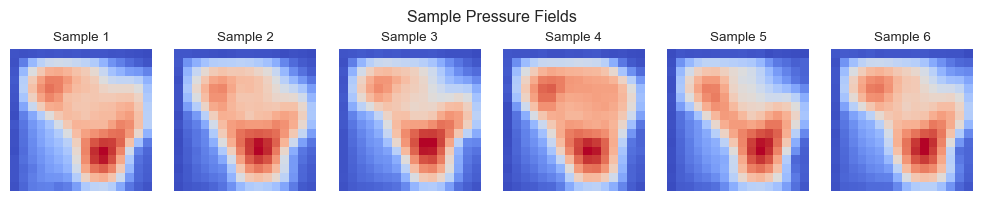

In [41]:
# Plot 6 samples
num_samples = 6
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(pred_p[i], cmap="coolwarm")
    plt.title(f"Sample {i+1}")
    plt.axis("off")
plt.suptitle("Sample Pressure Fields")
plt.tight_layout()
plt.show()

In [42]:
# Calculate mean and max pressure
mean_p = pred_p.mean(dim=(1, 2)) 
print(f"Mean Pressure shape {mean_p.shape}") 
max_p = pred_p.amax(dim=(1, 2))  
print(f"Max Pressure shape {max_p.shape}")  

Mean Pressure shape torch.Size([1000])
Max Pressure shape torch.Size([1000])


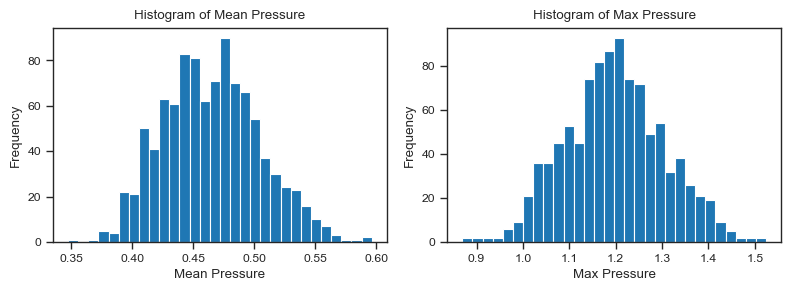

In [43]:
# Histogram of mean and max Pressures
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(mean_p.numpy(), bins=30)
plt.title("Histogram of Mean Pressure")
plt.xlabel("Mean Pressure")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(max_p.numpy(), bins=30)
plt.title("Histogram of Max Pressure")
plt.xlabel("Max Pressure")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [44]:
mean_field = pred_p.mean(dim=0)      
var_field = pred_p.var(dim=0)  
print(f"Shape of mean and variance of pressure field: {mean_field.shape} and {var_field.shape}")      

Shape of mean and variance of pressure field: torch.Size([16, 16]) and torch.Size([16, 16])


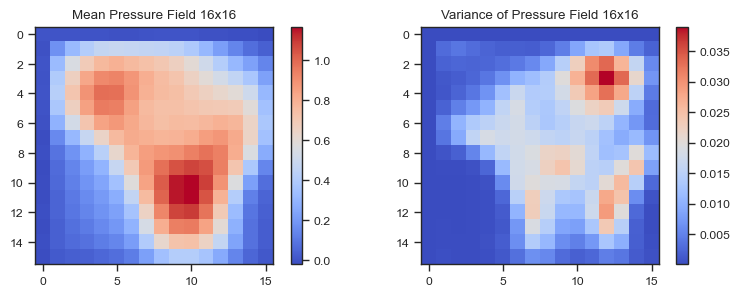

In [45]:
# Plot 'em 16x16 first
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(mean_field, cmap="coolwarm")
plt.title("Mean Pressure Field 16x16")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(var_field, cmap="coolwarm")
plt.title("Variance of Pressure Field 16x16")
plt.colorbar()
plt.tight_layout()
plt.show()

In [46]:
# Lets now iterpolates FNO outputs to 24×24
pred_p_upsampled = torch.nn.functional.interpolate(
    pred_p.unsqueeze(1), size=(24, 24), mode='bilinear'
).squeeze(1)  
mean_field_24 = pred_p_upsampled.mean(dim=0)  
var_field_24 = pred_p_upsampled.var(dim=0)    
mean_field_24.shape

torch.Size([24, 24])

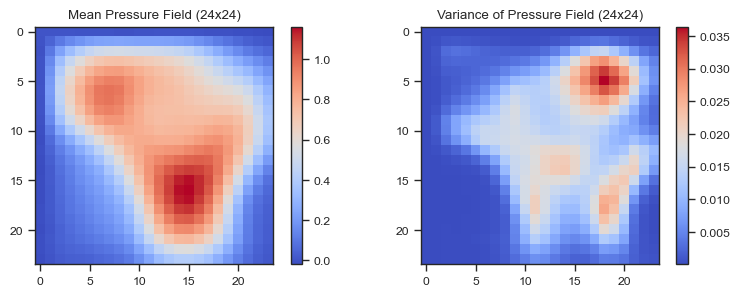

In [47]:
# Plot
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(mean_field_24, cmap="coolwarm")
plt.title("Mean Pressure Field (24x24)")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(var_field_24, cmap="coolwarm")
plt.title("Variance of Pressure Field (24x24)")
plt.colorbar()
plt.tight_layout()
plt.show()

torch.Size([1000])
torch.Size([16, 16])


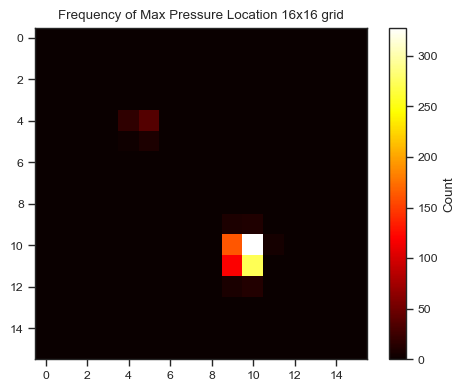

In [48]:
max_indices = torch.argmax(pred_p.view(1000, -1), dim=1) 
print(max_indices.shape)
counts = torch.bincount(max_indices, minlength=16*16).reshape(16, 16)
print(counts.shape)
plt.figure(figsize=(5, 4))
plt.imshow(counts, cmap="hot")
plt.title("Frequency of Max Pressure Location 16x16 grid")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()


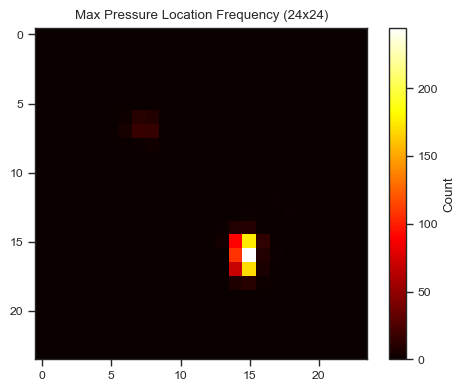

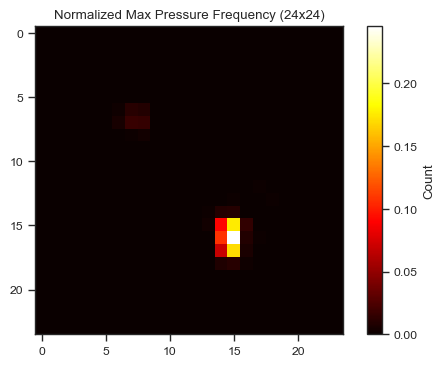

In [49]:
# Now on the 24×24 grid
flat_preds = pred_p_upsampled.view(1000, -1)
max_indices = torch.argmax(flat_preds, dim=1)  
counts_24 = torch.bincount(max_indices, minlength=24*24).reshape(24, 24)

# Plot heatmap
plt.figure(figsize=(5, 4))
plt.imshow(counts_24, cmap="hot")
plt.title("Max Pressure Location Frequency (24x24)")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()
# Normalized 
plt.figure(figsize=(6, 4))
plt.imshow(counts_24 / 1000, cmap="hot")  
plt.title("Normalized Max Pressure Frequency (24x24)")
plt.colorbar(label="Count")
plt.show()